In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.2.1.dev0


In [3]:
import scipy
scipy.__version__

'1.3.1'

In [4]:
import json

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u

import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

In [5]:
plot_dir = '../../paper/figures/'

In [6]:
# Stellar parameters
with open(base_dir + "mass_radius.json", "r") as f:
    data = json.load(f)
    mass_radius_mu = np.array(data["mean"])
    mass_radius_cov = np.array(data["cov"])

In [7]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

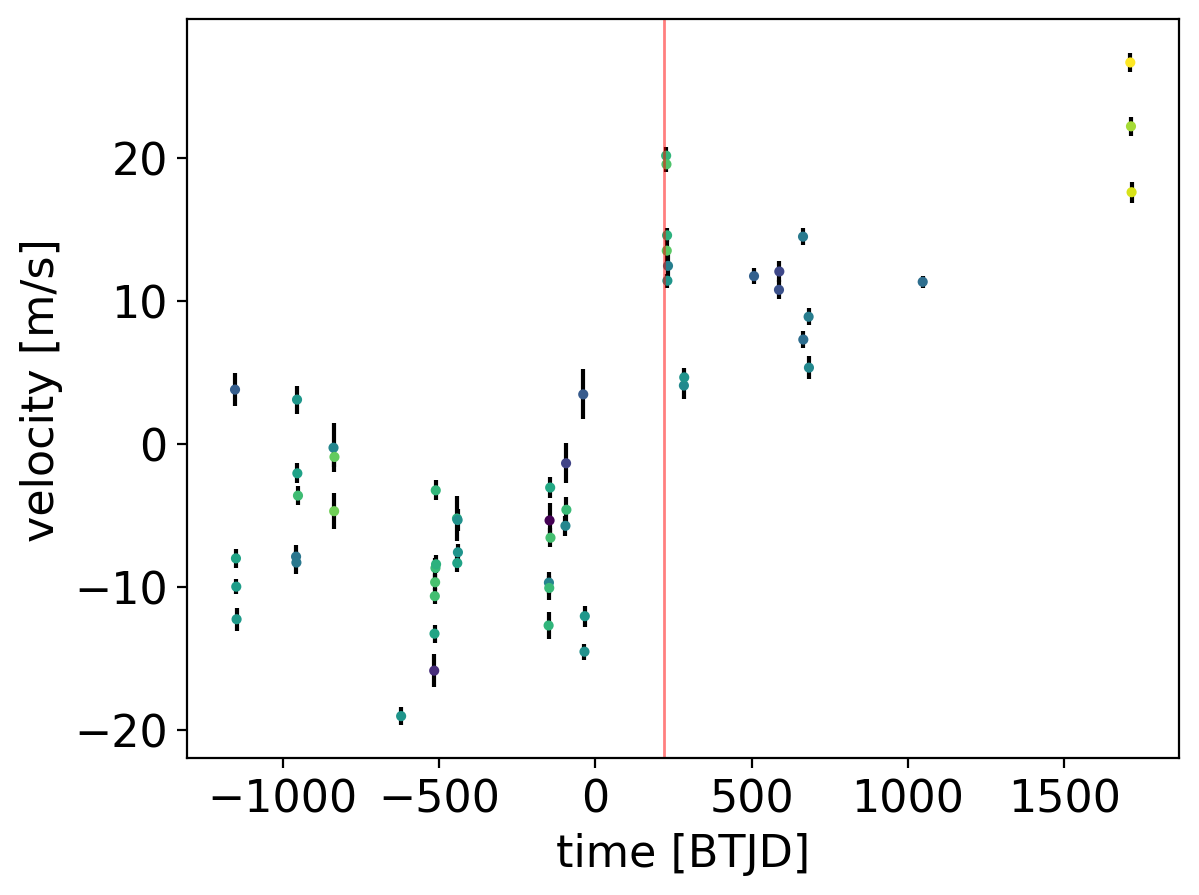

In [8]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
HARPS_upgrade -= BTJD_ref
pug = np.ascontiguousarray(x_rv >= HARPS_upgrade, dtype=bool) # stands for post-upgrade, obviously
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
bis_rv = np.ascontiguousarray((df.bis - df.bis.mean()) / df.bis.std(), dtype=np.float64)
fwhm_rv = np.ascontiguousarray((df.fwhm - df.fwhm.mean()) / df.fwhm.std(), dtype=np.float64)
shk = np.ascontiguousarray(df.s_hk, dtype=np.float64)
yerr_shk = np.ascontiguousarray(df.e_s_hk, dtype=np.float64)



t = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
plt.scatter(x_rv, y_rv, c=shk, s=7)
plt.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
plt.xlabel("time [BTJD]")
plt.ylabel("velocity [m/s]");

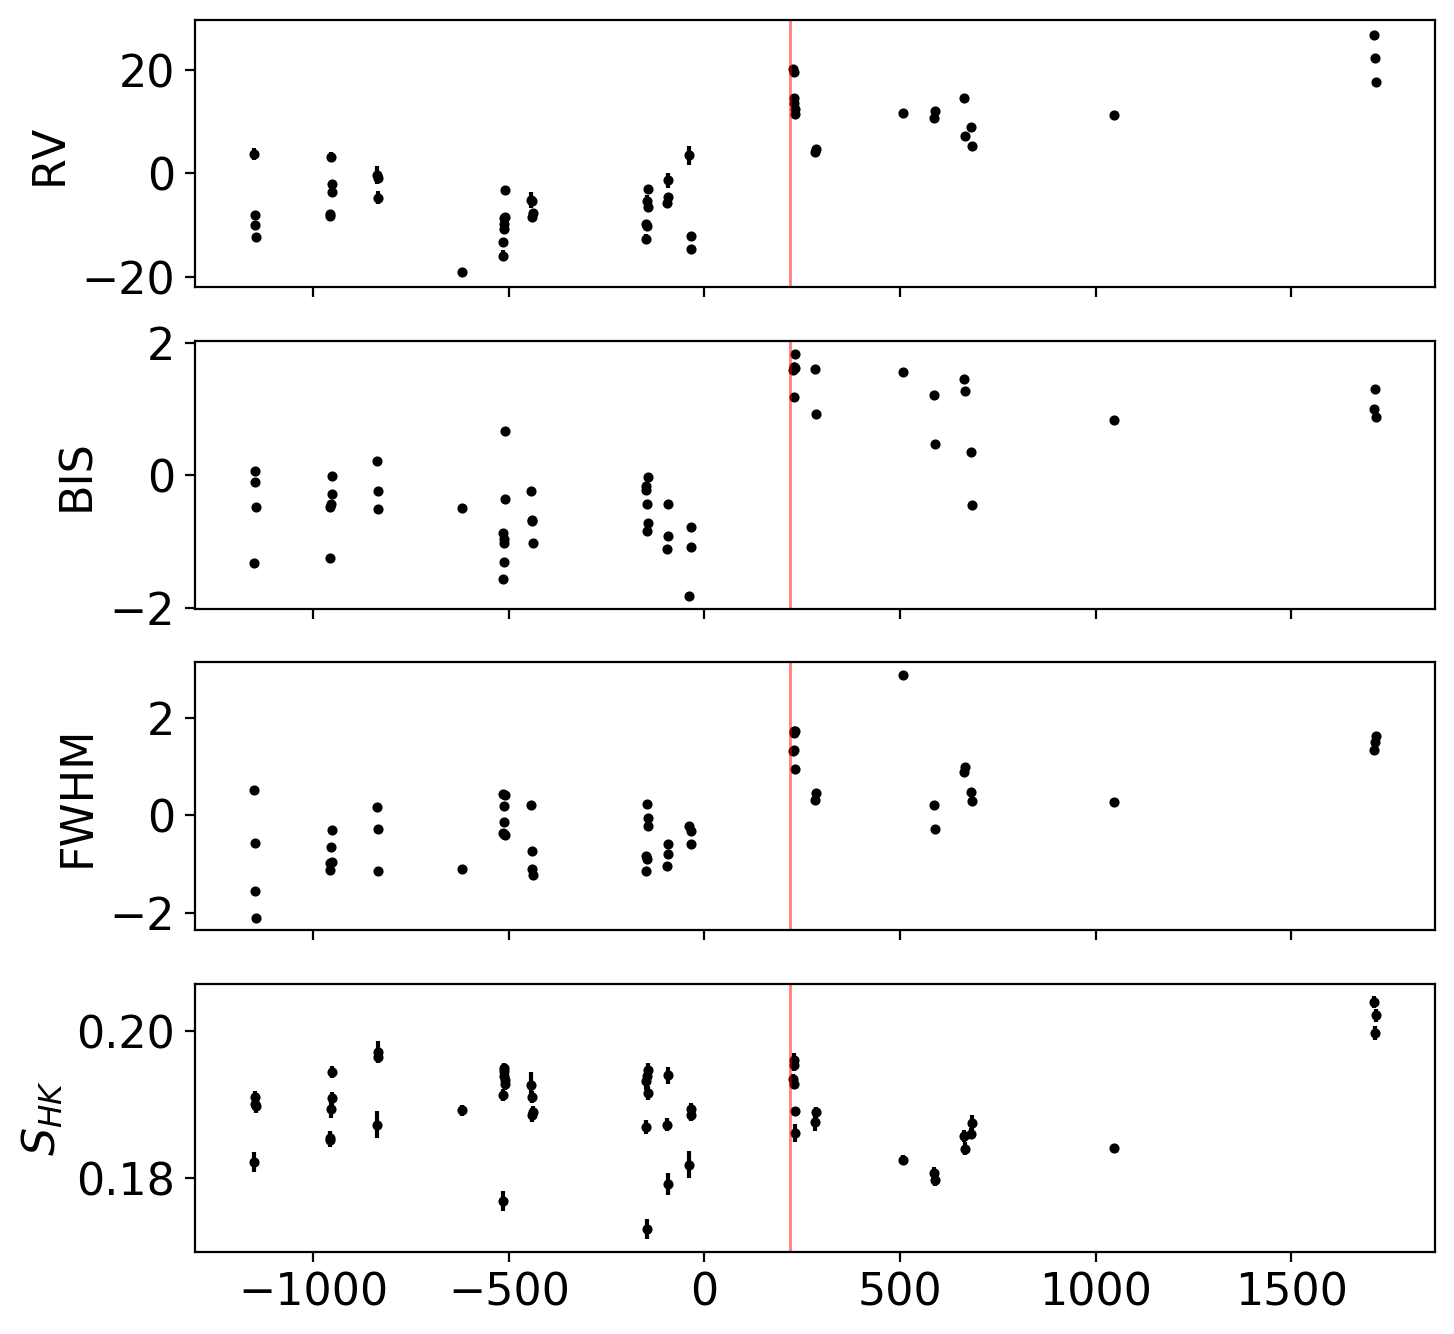

In [9]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(8,8), sharex=True)
ax1.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
ax1.scatter(x_rv, y_rv, c='k', s=7)
ax1.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax1.set_ylabel('RV')

ax2.scatter(x_rv, bis_rv, c='k', s=7)
ax2.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax2.set_ylabel('BIS')

ax3.scatter(x_rv, fwhm_rv, c='k', s=7)
ax3.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax3.set_ylabel('FWHM')

ax4.errorbar(x_rv, shk, yerr=yerr_shk, fmt=",k", zorder=-10)
ax4.scatter(x_rv, shk, c='k', s=7)
ax4.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax4.set_ylabel('$S_{HK}$');

peaks at:
34.60 days
34.52 days
99.98 days
1.09 days
99.29 days
59.15 days
1.01 days
1.09 days
1.01 days
504.36 days


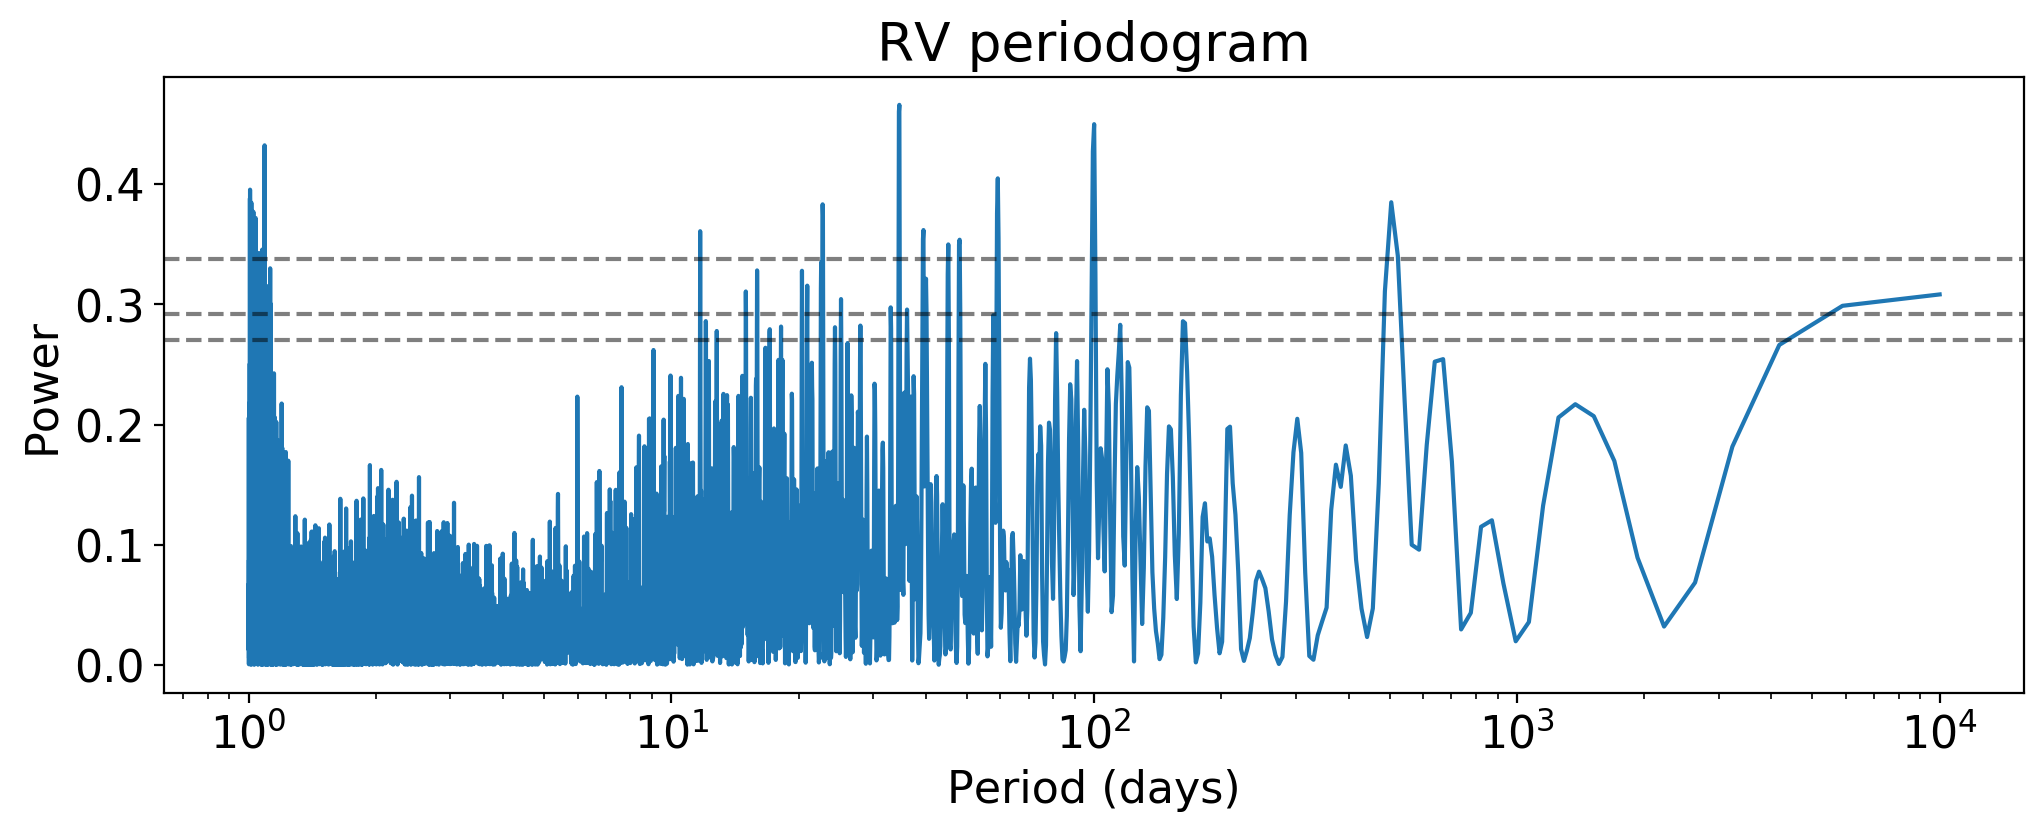

In [10]:
y_rv_guess = np.copy(y_rv)
y_rv_guess[pug] -= 15.4

from astropy.timeseries import LombScargle
ls = LombScargle(x_rv, y_rv_guess, yerr_rv)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5, ls='--')
ax.set_xscale('log')
ax.set_title('RV periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

Pearson R is 0.4587 with a false-alarm probability of 0.0004


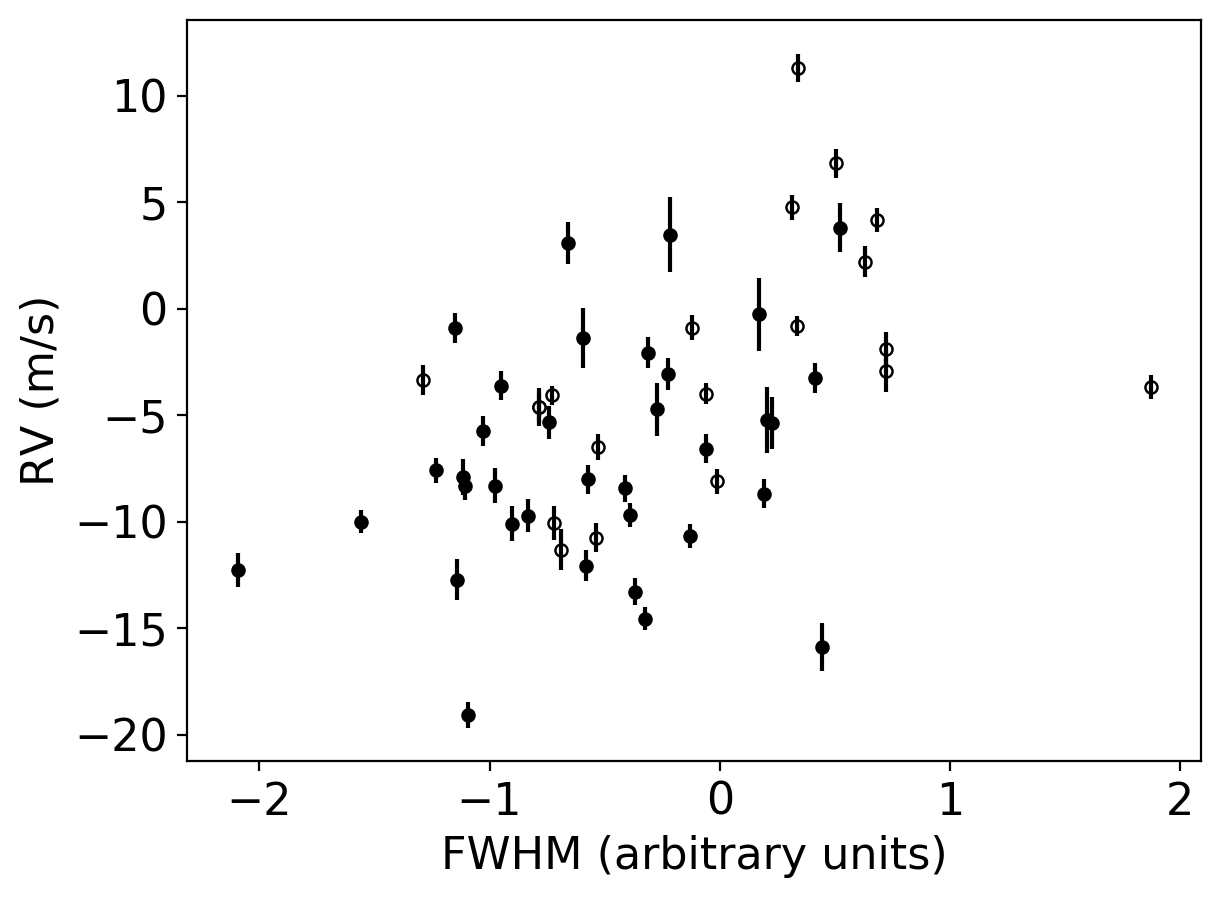

In [11]:
fwhm_rv_guess = np.copy(fwhm_rv)
fwhm_rv_guess[pug] -= 1.

plt.errorbar(fwhm_rv_guess, y_rv_guess, yerr=yerr_rv, fmt=",k")
plt.scatter(fwhm_rv_guess, y_rv_guess, c='k', s=18)
plt.scatter(fwhm_rv_guess[pug], y_rv_guess[pug], c='w', s=6)
plt.xlabel('FWHM (arbitrary units)')
plt.ylabel('RV (m/s)')

from scipy.stats import pearsonr
print("Pearson R is {0:.4f} with a false-alarm probability of {1:.4f}".format(*pearsonr(fwhm_rv_guess, y_rv_guess)))

mask = (fwhm_rv_guess > 1.8) | (fwhm_rv_guess > 0) & (y_rv_guess < -15)
#plt.scatter(fwhm_rv_guess[mask], y_rv_guess[mask], c='r', s=20);

plt.tight_layout()
plt.savefig(plot_dir+'rv_fwhm_corr.pdf')

peaks at:
30.88 days
30.94 days
1.03 days
1.03 days
30.81 days
31.01 days
1.02 days
1.02 days
19.53 days
1.03 days


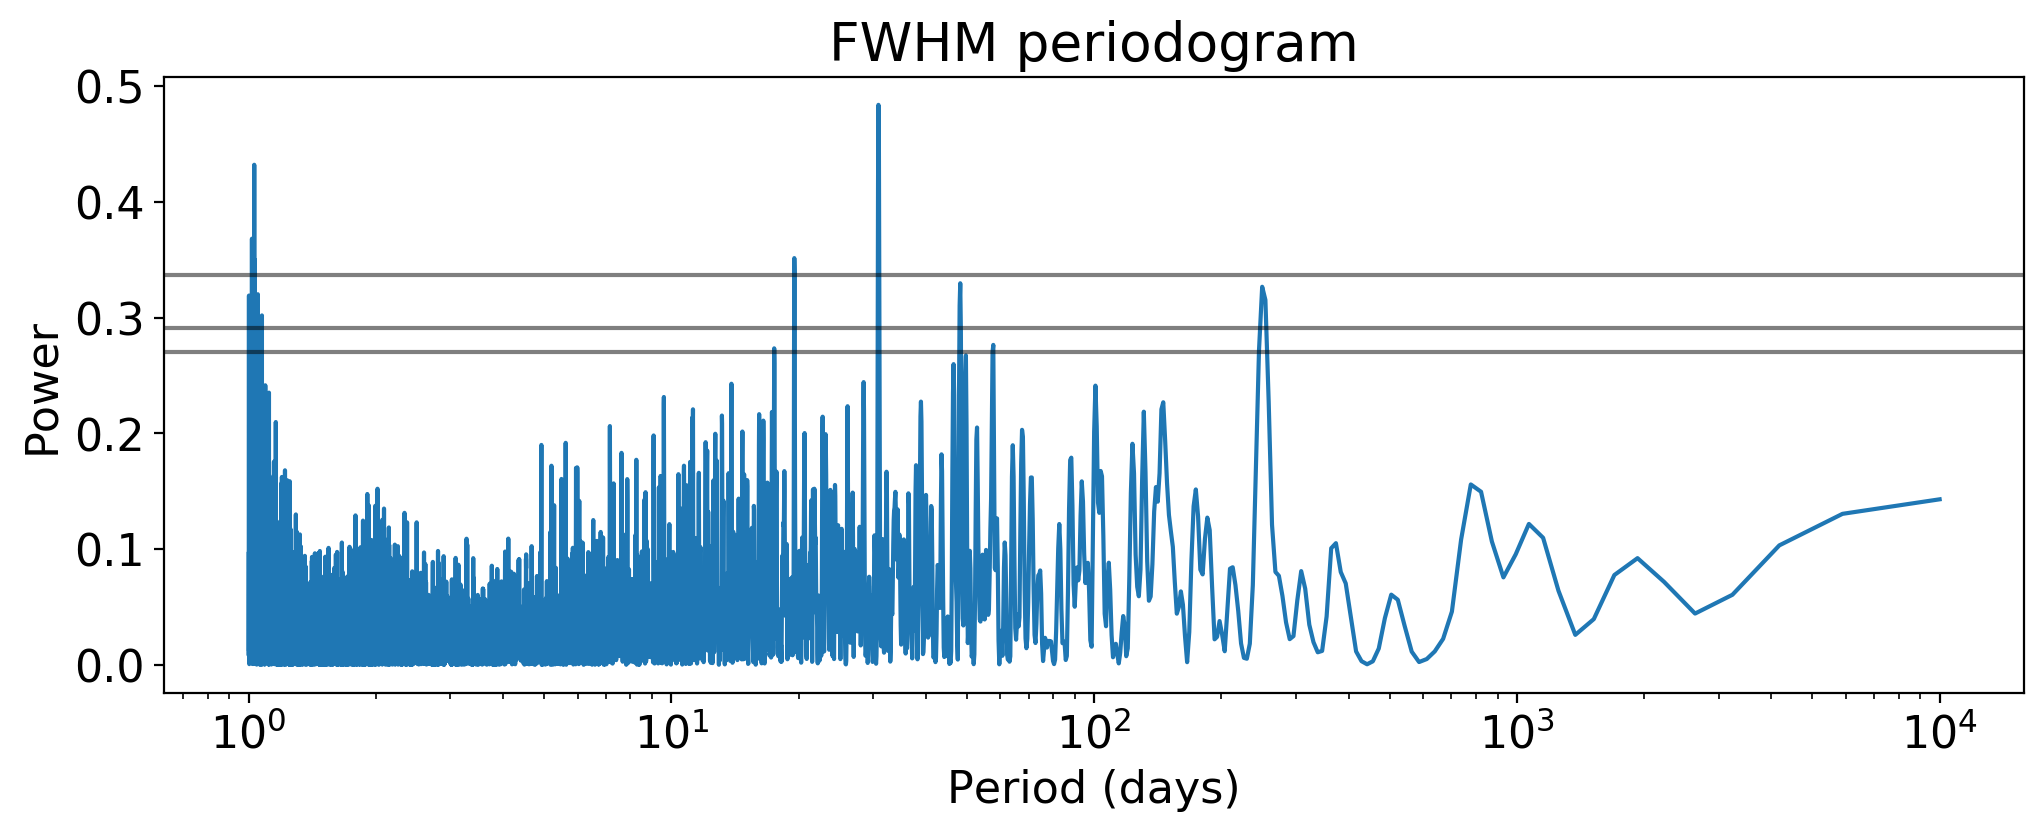

In [12]:
ls = LombScargle(x_rv, fwhm_rv_guess)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('FWHM periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

Pearson R is 0.3204 with a false-alarm probability of 0.0171


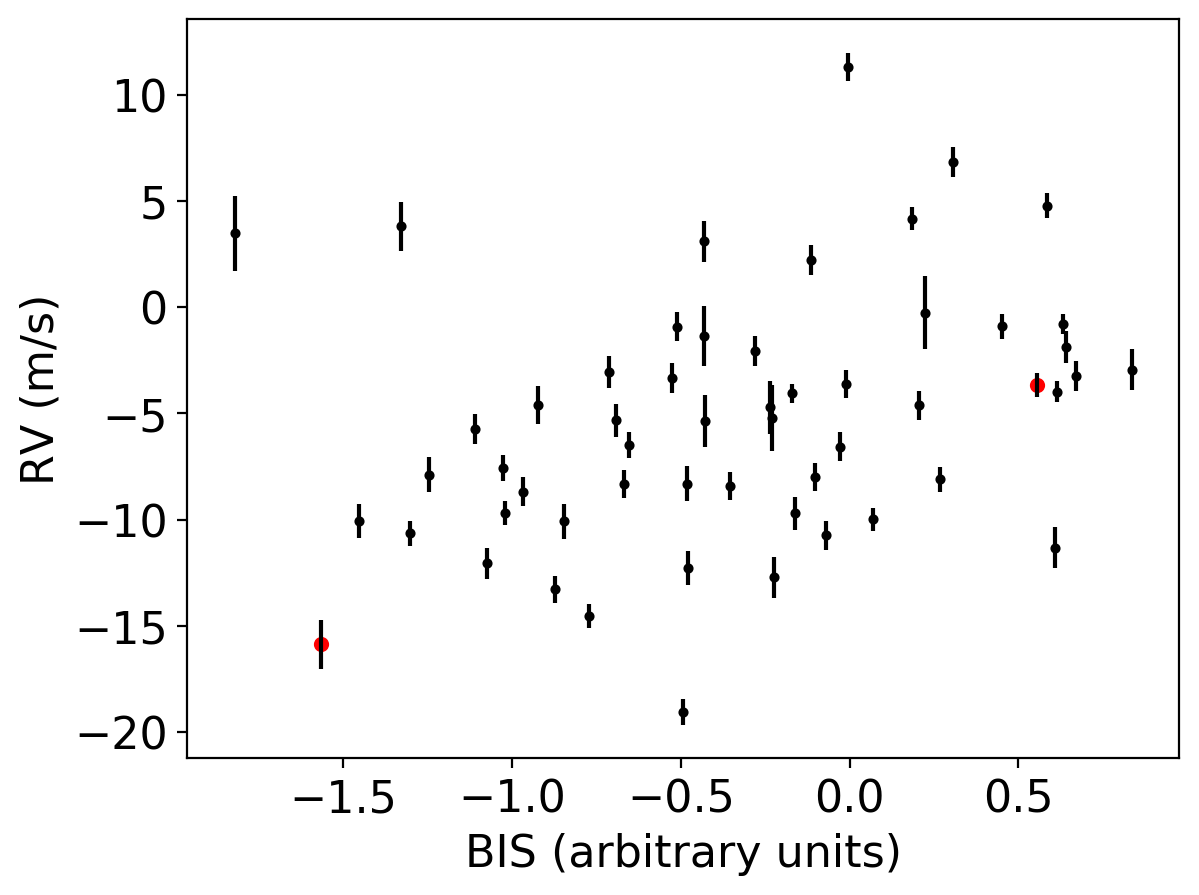

In [13]:
bis_rv_guess = np.copy(bis_rv)
bis_rv_guess[pug] -= 1.

plt.errorbar(bis_rv_guess, y_rv_guess, yerr=yerr_rv, fmt=",k")
plt.scatter(bis_rv_guess, y_rv_guess, c='k', s=7)
plt.xlabel('BIS (arbitrary units)')
plt.ylabel('RV (m/s)')

from scipy.stats import pearsonr
print("Pearson R is {0:.4f} with a false-alarm probability of {1:.4f}".format(*pearsonr(bis_rv_guess, y_rv_guess)))

plt.scatter(bis_rv_guess[mask], y_rv_guess[mask], c='r', s=20);

peaks at:
1.01 days
71.19 days
1.01 days
71.55 days
1.01 days
70.84 days
1.01 days
1.01 days
70.49 days
1.05 days


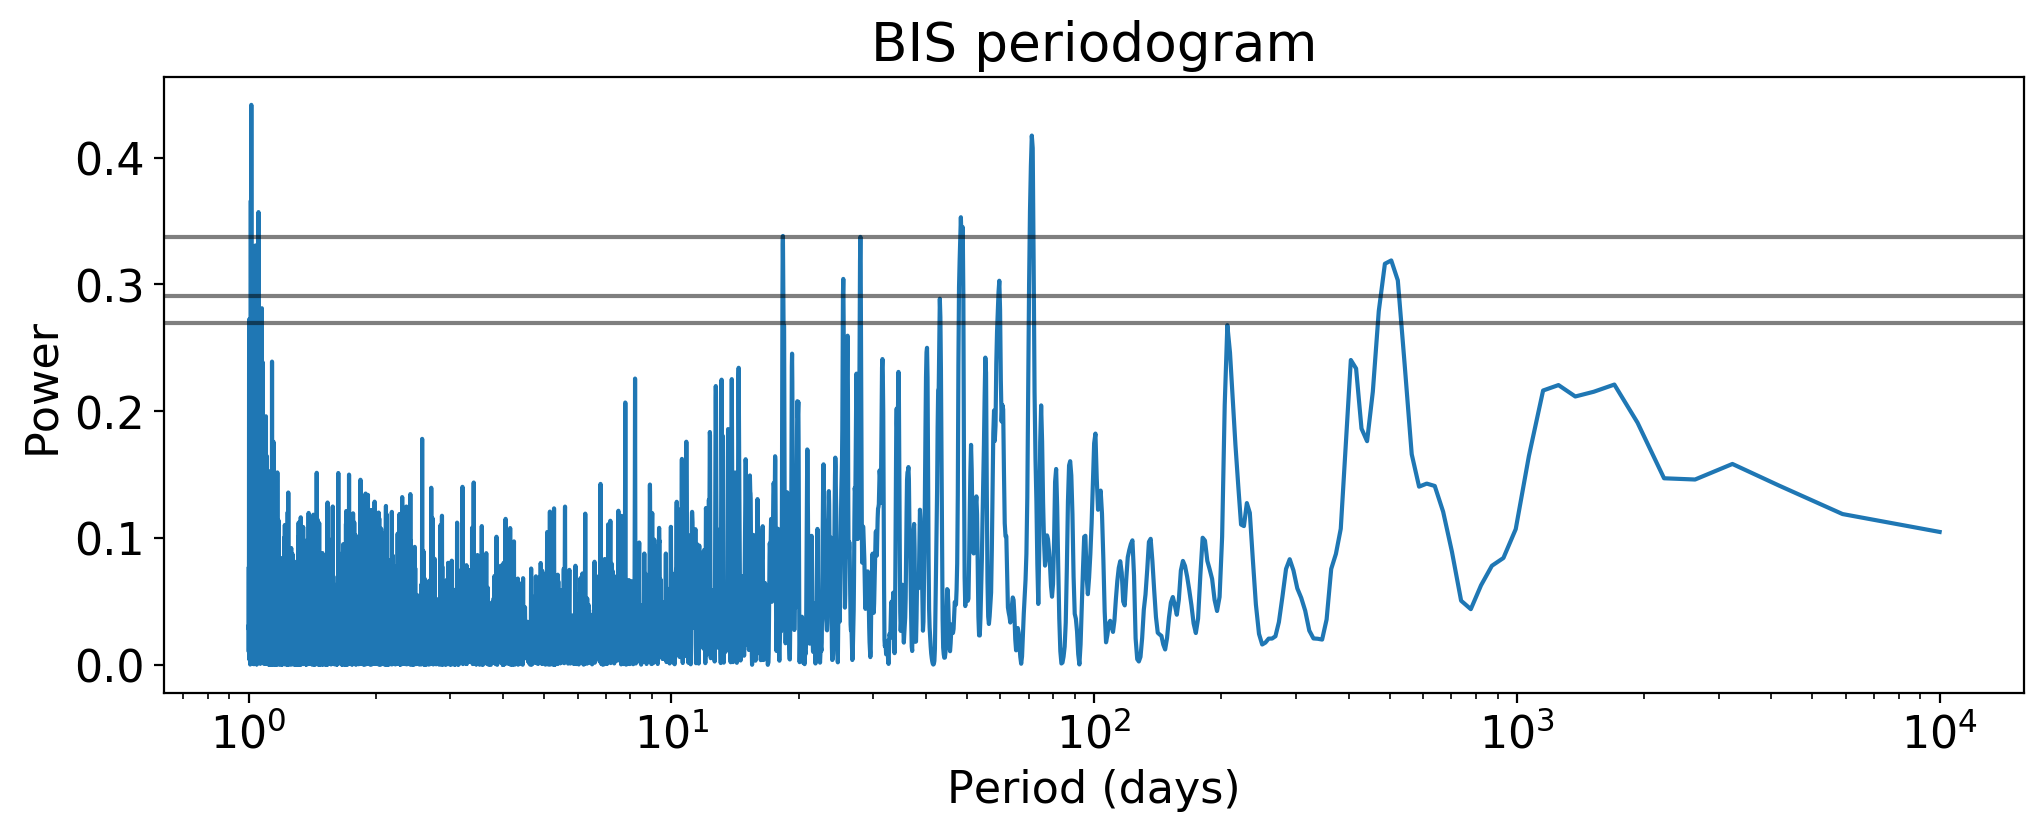

In [14]:
ls = LombScargle(x_rv, bis_rv_guess)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('BIS periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

Pearson R is 0.2432 with a false-alarm probability of 0.0736


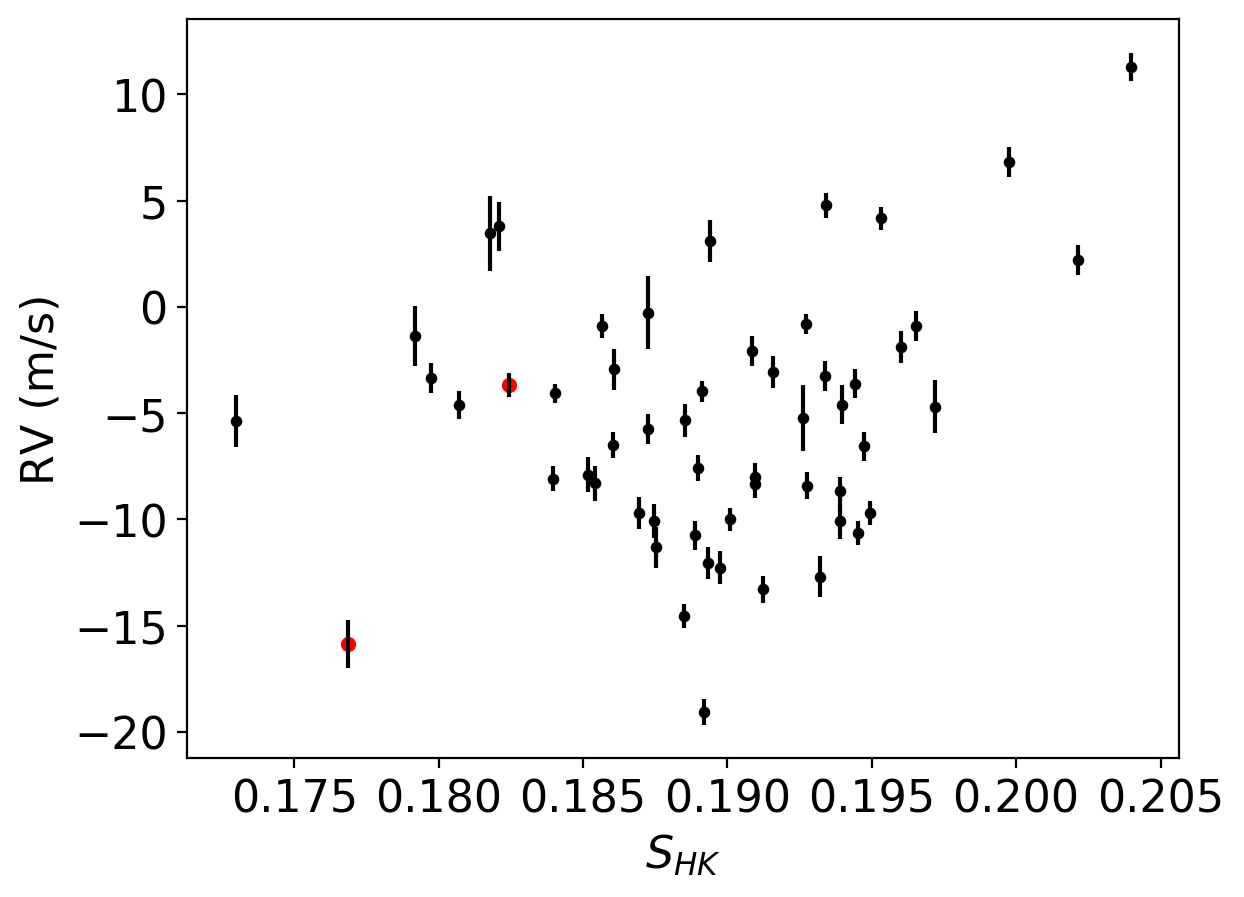

In [15]:
plt.errorbar(shk, y_rv_guess, yerr=yerr_rv, fmt=",k")
plt.scatter(shk, y_rv_guess, c='k', s=10)
plt.xlabel('$S_{HK}$')
plt.ylabel('RV (m/s)')

from scipy.stats import pearsonr
print("Pearson R is {0:.4f} with a false-alarm probability of {1:.4f}".format(*pearsonr(shk, y_rv_guess)))

plt.scatter(shk[mask], y_rv_guess[mask], c='r', s=20);

peaks at:
1.11 days
1.11 days
9.76 days
9.77 days
1.05 days
1.05 days
1.04 days
1.04 days
1.05 days
19.32 days


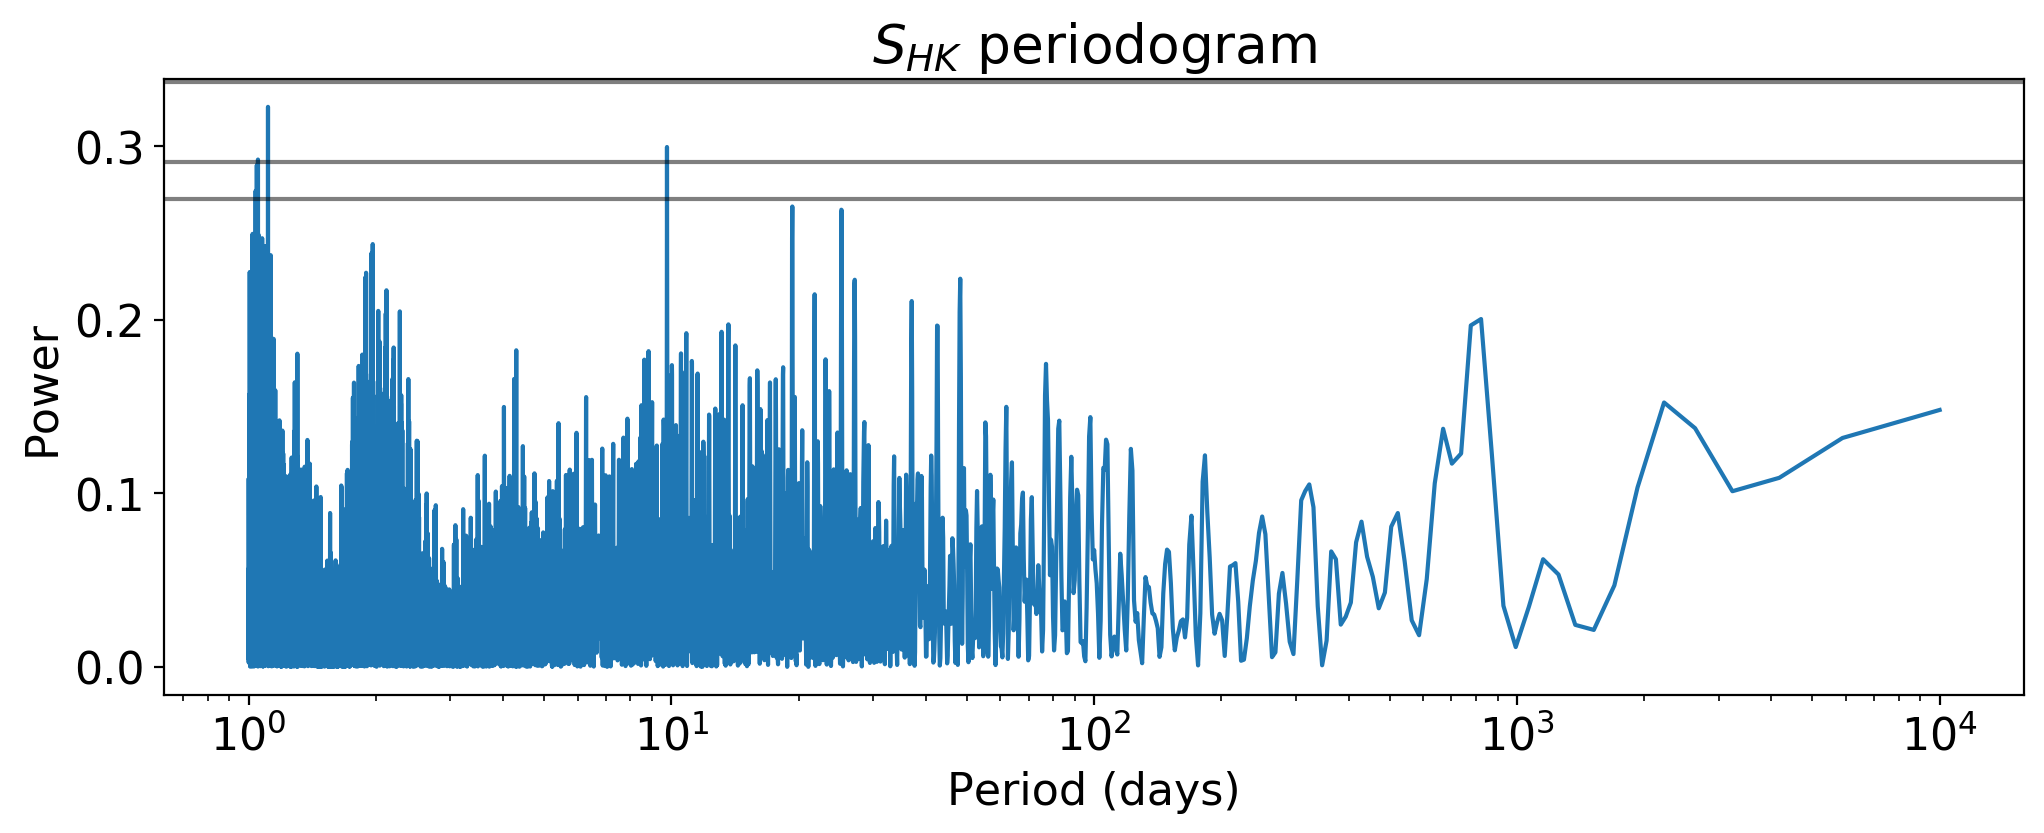

In [16]:
ls = LombScargle(x_rv, shk)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('$S_{HK}$ periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

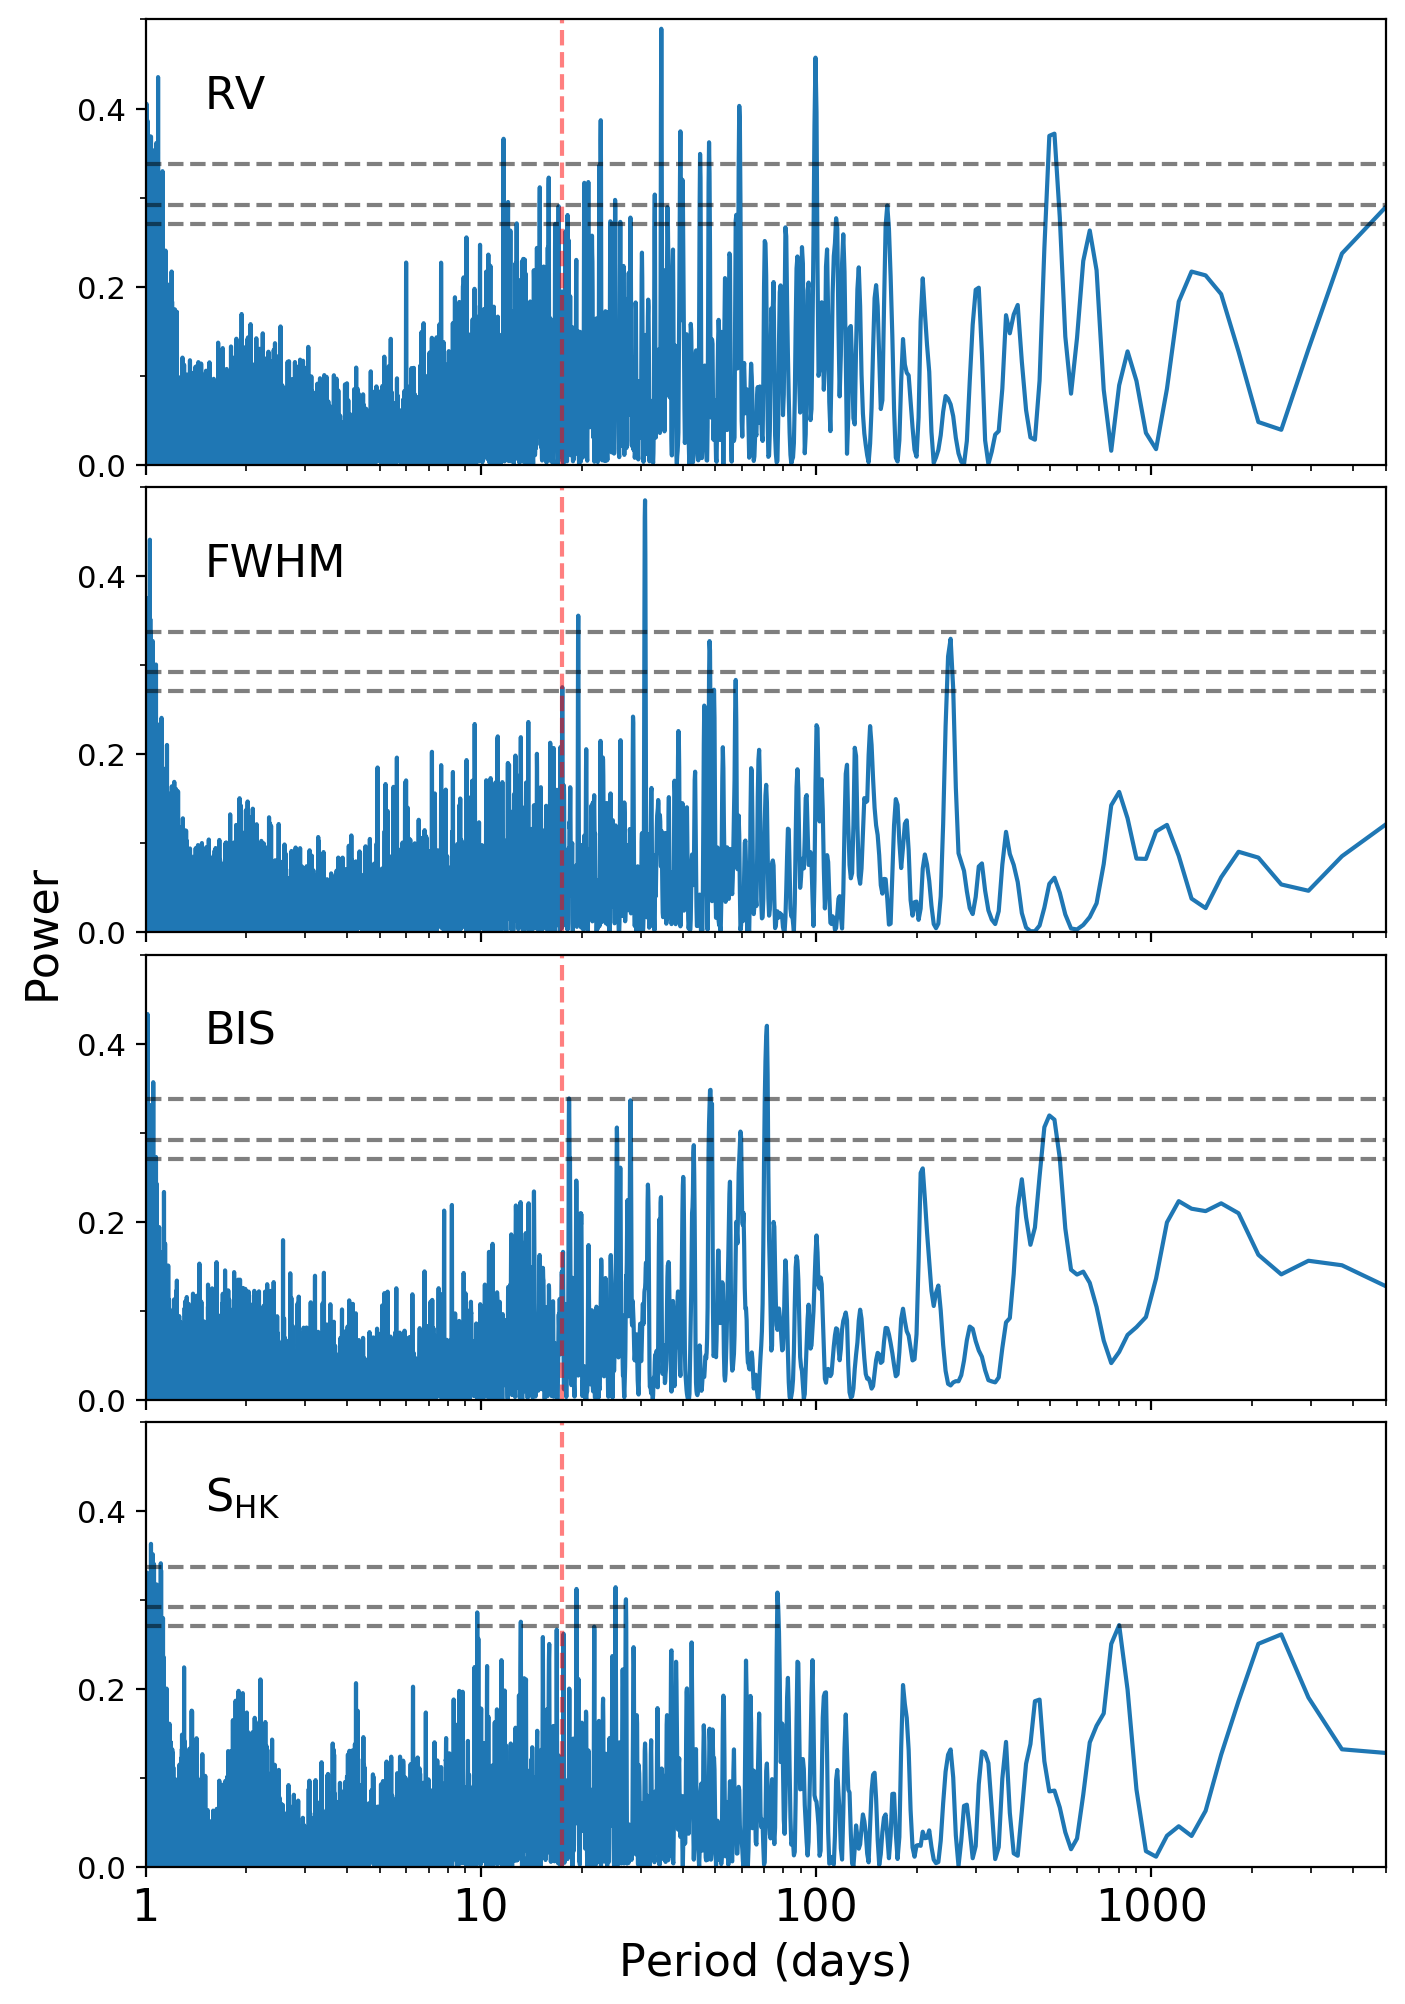

In [17]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8,12), sharex=True)

ls = LombScargle(x_rv, y_rv_guess, yerr_rv)
freq, power = ls.autopower(minimum_frequency=2.e-4, maximum_frequency=1.)
probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities) 
ax1.plot(1./freq, power)
ax1.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax1.axhline(f, c='k', alpha=0.5, ls='--')
ax1.text(1.5, 0.4, 'RV')

power = LombScargle(x_rv, fwhm_rv_guess).power(freq)
fal = ls.false_alarm_level(probabilities) 
ax2.plot(1./freq, power)
ax2.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax2.axhline(f, c='k', alpha=0.5, ls='--')
ax2.text(1.5, 0.4, 'FWHM')

power = LombScargle(x_rv, bis_rv_guess).power(freq)
fal = ls.false_alarm_level(probabilities) 
ax3.plot(1./freq, power)
ax3.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax3.axhline(f, c='k', alpha=0.5, ls='--')
ax3.text(1.5, 0.4, 'BIS')

power = LombScargle(x_rv, shk, yerr_shk).power(freq)
fal = ls.false_alarm_level(probabilities) 
ax4.plot(1./freq, power)
ax4.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax4.axhline(f, c='k', alpha=0.5, ls='--')
ax4.text(1.5, 0.4, 'S$_{\mathrm{HK}}$')

for ax in (ax1,ax2,ax3,ax4):
    ax.set_ylim([0.,0.5])
    ax.set_yticks([0.,0.2,0.4], minor=False)
    ax.set_yticks([0.1,0.3,0.5], minor=True)
    ax.tick_params(labelsize='x-small', axis='y')


ax1.set_xscale('log')
ax1.set_xlim([1.,5.e3])
ax4.set_xlabel('Period (days)')
ax4.set_xticklabels(['0.1','1', '10', '100', '1000'])

fig.text(0.06,0.5,'Power',rotation=90,va='center',ha='center')
plt.subplots_adjust(hspace=0.05)
plt.savefig(plot_dir+'periodograms.pdf');

#### Fit an initial model without planets:

In [18]:
t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(start=None, bis=False, fwhm=False, rv_trend_order=1):
    if rv_trend_order < 1:
        assert False, "rv_trend_order must be >= 1"
    with pm.Model() as model:
        # RV jitter & a quadratic RV trend
        #logs_rv_pre = pm.Normal("logs_rv_pre", mu=np.log(np.median(yerr_rv[~pug])), sd=5)
        #logs_rv_pug = pm.Normal("logs_rv_pug", mu=np.log(np.median(yerr_rv[pug])), sd=5)
        offset_pug = pm.Normal("offset_pug", mu=15.4, sd=0.4) # strong prior based on other solar twins
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(rv_trend_order))[::-1], shape=rv_trend_order)
        if bis:
            offset_pug_bis = pm.Normal("offset_pug_bis", mu=1., sd=5) # weak prior from eyeballing
            trend_bis = pm.Normal("trend_bis", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
        if fwhm:
            offset_pug_fwhm = pm.Normal("offset_pug_fwhm", mu=1., sd=5) # weak prior from eyeballing
            trend_fwhm = pm.Normal("trend_fwhm", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)

        # Define the background RV model
        A = np.vander(x_rv, rv_trend_order)
        bkg_terms = pug*offset_pug + tt.dot(A, trend)
        if bis:
            A_bis = np.vander(bis_rv, 2)
            bkg_terms += tt.dot(A_bis, trend_bis) + pug*offset_pug_bis*trend_bis[0]
            bis_offset = pm.Deterministic("bis_offset", pug*offset_pug_bis)
        if fwhm:
            A_fwhm = np.vander(fwhm_rv, 2)
            bkg_terms += tt.dot(A_fwhm, trend_fwhm) + pug*offset_pug_fwhm*trend_fwhm[0] 
            fwhm_offset = pm.Deterministic("fwhm_offset", pug*offset_pug_fwhm)
        bkg = pm.Deterministic("bkg", bkg_terms)
        
        rv_offset = pm.Deterministic("rv_offset", pug*offset_pug + tt.dot(A, trend))
        


        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", bkg)
        
        err_pre = tt.sqrt(yerr_rv[~pug]**2)
        err_pug = tt.sqrt(yerr_rv[pug]**2)
        pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])
        
        #err_pre = tt.sqrt(yerr_rv[~pug]**2 + tt.exp(2*logs_rv_pre))
        #err_pug = tt.sqrt(yerr_rv[pug]**2 + tt.exp(2*logs_rv_pug))
        #pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        #pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])
        
        pug_pred = t_rv >= HARPS_upgrade
        A_pred = np.vander(t_rv, rv_trend_order)
        bkg_pred = pm.Deterministic("bkg_pred", pug_pred*offset_pug + tt.dot(A_pred, trend))

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[trend, offset_pug])
        if bis:
            map_soln = xo.optimize(start=map_soln, vars=[trend_bis, offset_pug_bis])
        if fwhm:
            map_soln = xo.optimize(start=map_soln, vars=[trend_fwhm, offset_pug_fwhm])
        #map_soln = xo.optimize(start=map_soln, vars=[logs_rv_pre, logs_rv_pug]) 
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [19]:
model, map_soln = build_model(fwhm=True, rv_trend_order=3)

optimizing logp for variables: [offset_pug, trend]
13it [00:00, 24.60it/s, logp=-1.309162e+03] 
message: Optimization terminated successfully.
logp: -3693.3050492693324 -> -1309.1621295643172
optimizing logp for variables: [offset_pug_fwhm, trend_fwhm]
20it [00:00, 335.07it/s, logp=-1.138845e+03] 
message: Optimization terminated successfully.
logp: -1309.1621295643172 -> -1138.8446674796523
optimizing logp for variables: [trend_fwhm, offset_pug_fwhm, trend, offset_pug]
64it [00:00, 642.27it/s, logp=-1.066285e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1138.8446674796523 -> -1066.284942228194


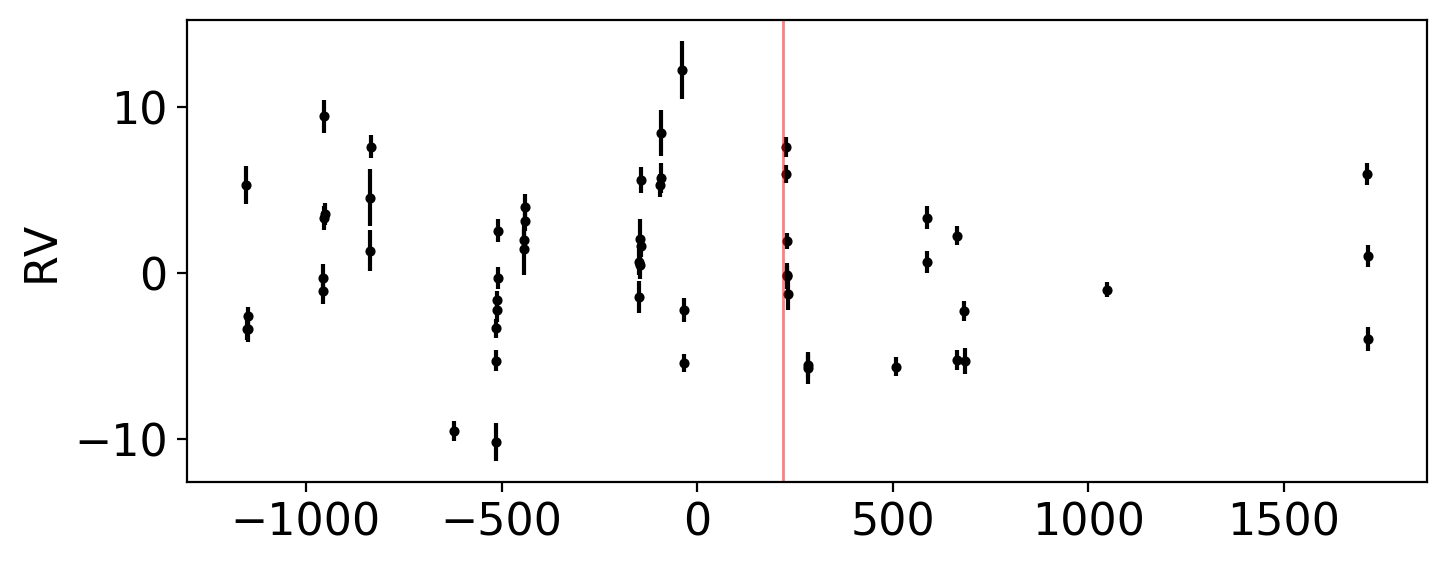

In [20]:
fig, ax1 = plt.subplots(1,1, figsize=(8,3), sharex=True)
ax1.errorbar(x_rv, y_rv - map_soln['bkg'], yerr=yerr_rv, fmt=",k", zorder=-10)
ax1.scatter(x_rv, y_rv - map_soln['bkg'], c='k', s=7)
ax1.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax1.set_ylabel('RV');

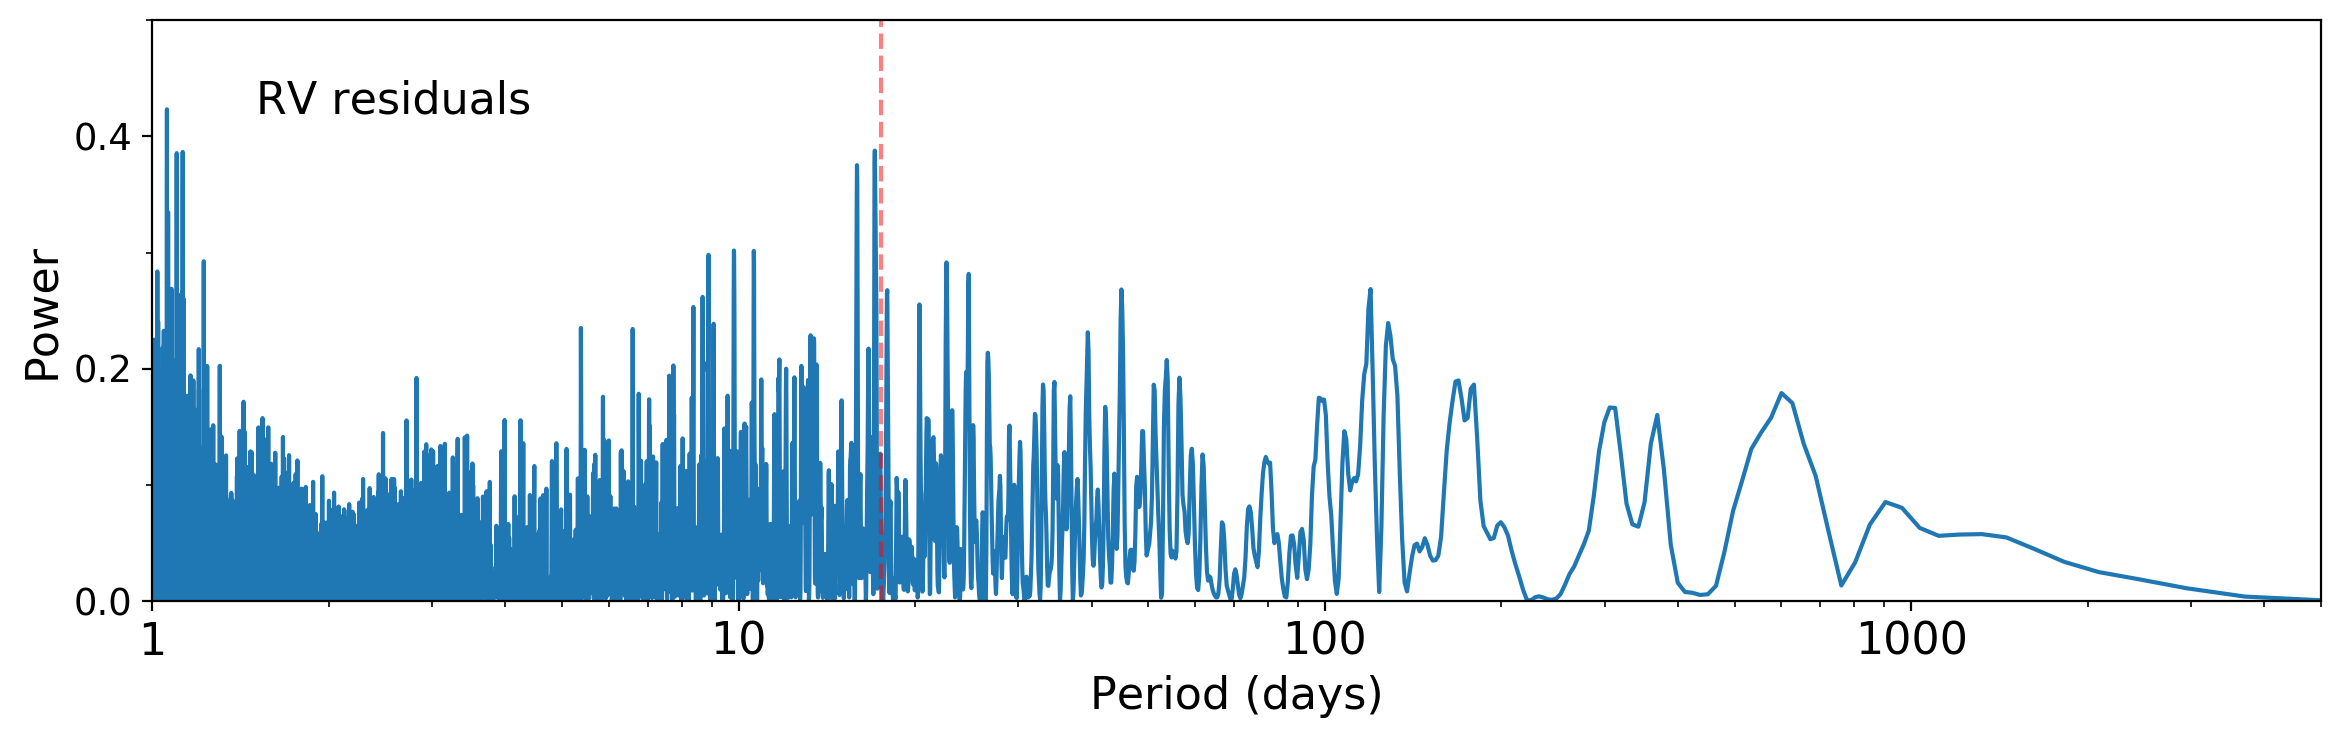

In [21]:
y_rv_resids = y_rv - map_soln['bkg']

ls = LombScargle(x_rv, y_rv_resids, yerr_rv)
freq, power = ls.autopower(minimum_frequency=2.e-4, maximum_frequency=1.)

probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
ax.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax1.axhline(f, c='k', alpha=0.5, ls='--')
ax.text(1.5, 0.42, 'RV residuals')
ax.set_xscale('log')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
ax.set_xlim([1.,5.e3])
ax.set_ylim([0.,0.5])
ax.set_yticks([0.,0.2,0.4], minor=False)
ax.set_yticks([0.1,0.3,0.5], minor=True)
ax.tick_params(labelsize='small', axis='y')
ax.set_xticklabels(['0.1','1', '10', '100', '1000'])
fig.tight_layout()
plt.savefig(plot_dir+'periodogram_resids1.pdf');

peaks at:
17.07 days
15.92 days
15.93 days
17.09 days
17.05 days
17.11 days
15.90 days
17.13 days
15.95 days
10.61 days


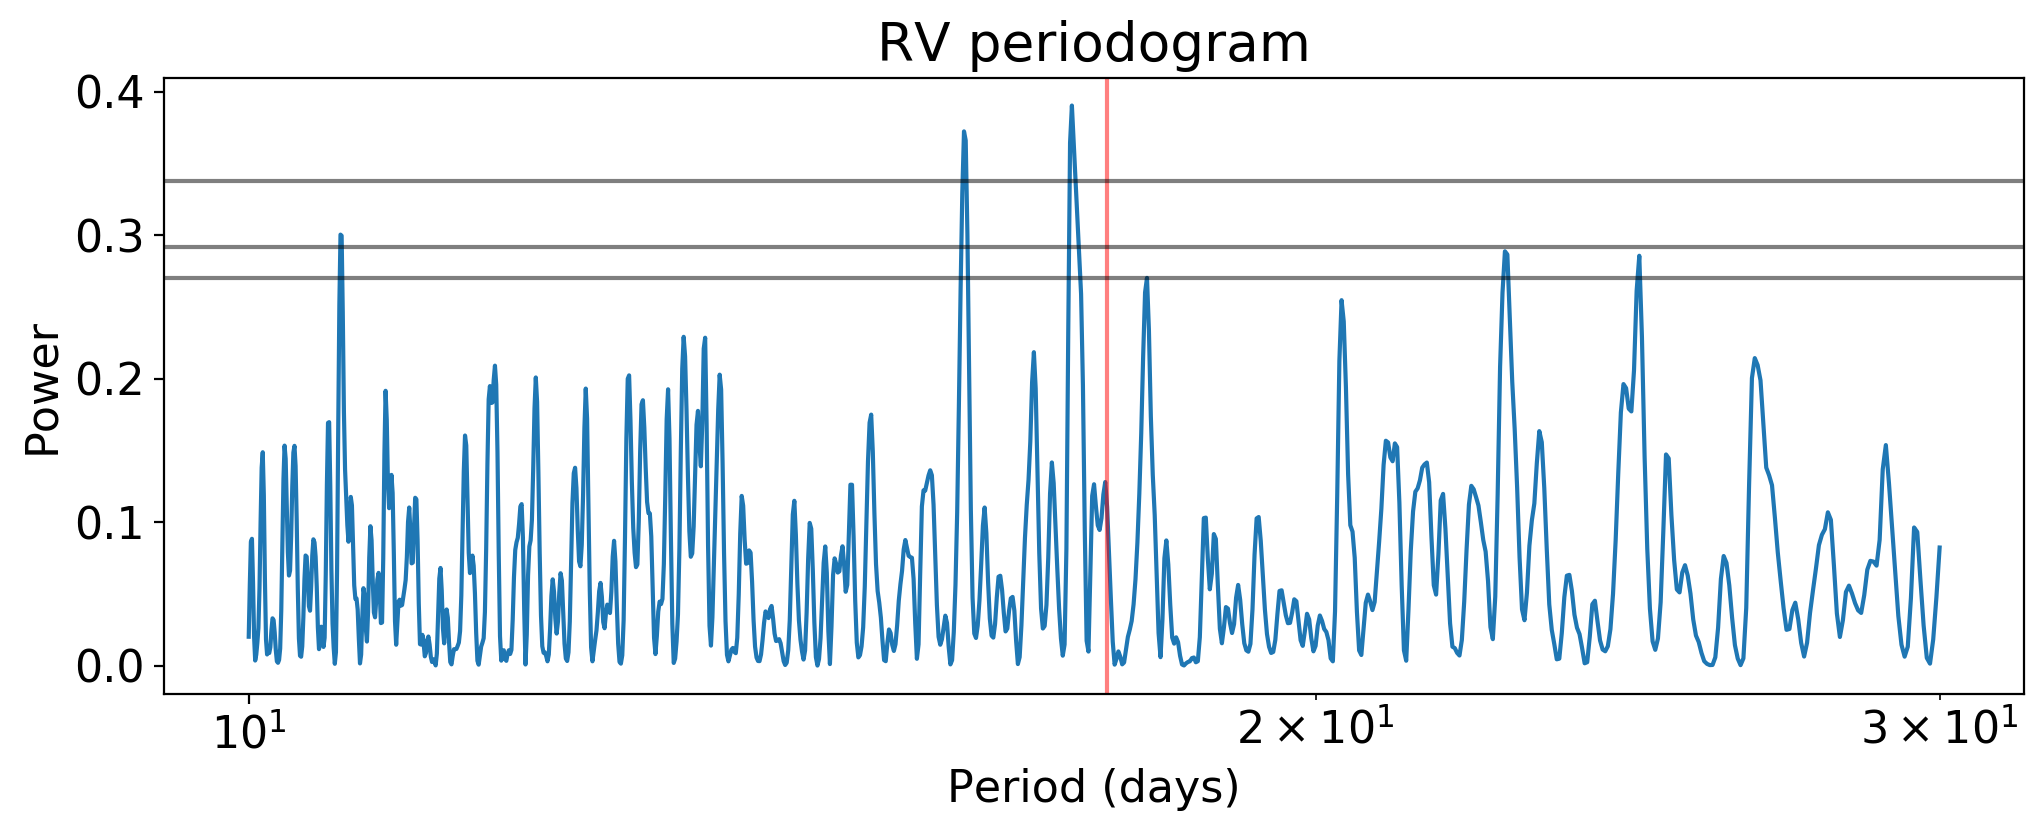

In [22]:
ls = LombScargle(x_rv, y_rv_resids, yerr_rv)
freq, power = ls.autopower(minimum_frequency=1./30.,
                                                   maximum_frequency=0.1)
probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
ax.axvline(17.47114, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('RV periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

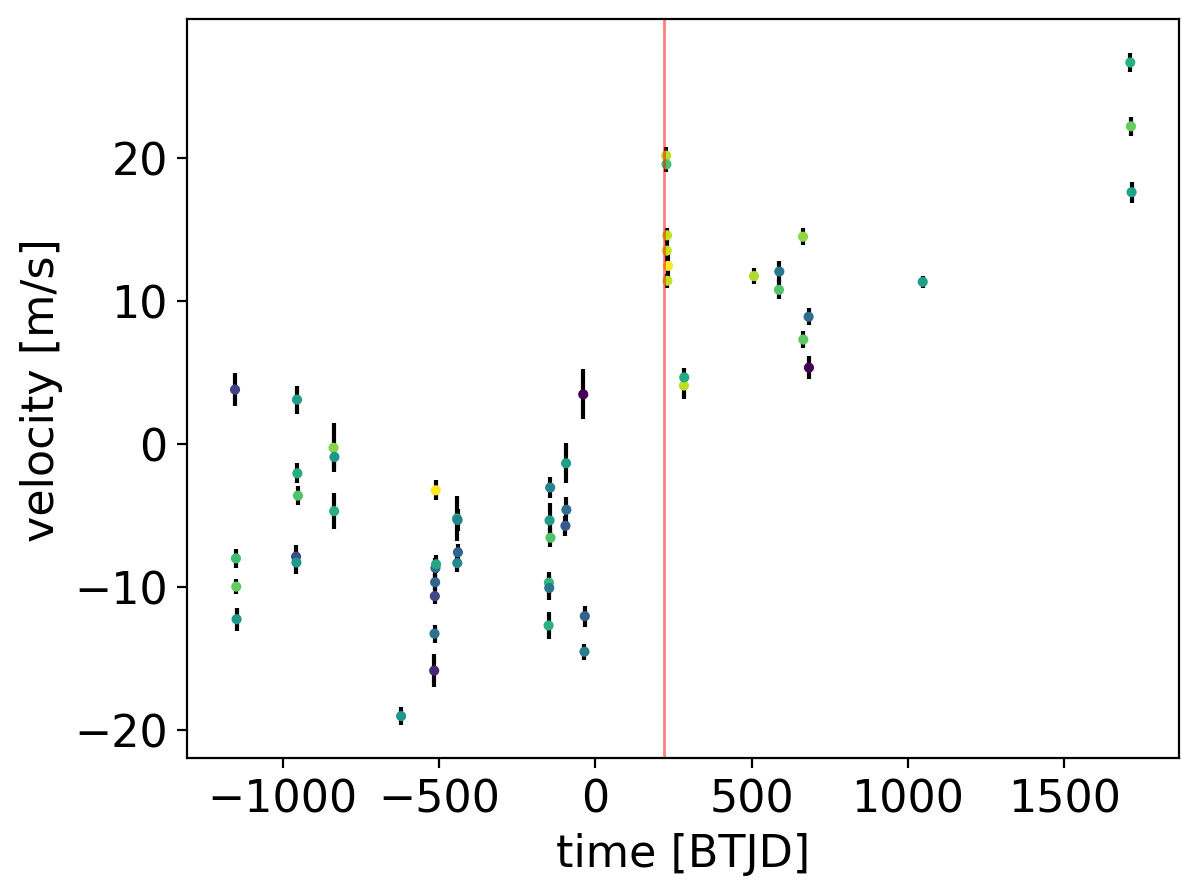

In [23]:
plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
plt.scatter(x_rv[~pug], y_rv[~pug], c=df.bis[~pug], s=7)
plt.scatter(x_rv[pug], y_rv[pug], c=df.bis[pug], s=7)
plt.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
plt.xlabel("time [BTJD]")
plt.ylabel("velocity [m/s]");

#### Now try adding in a planet:

In [24]:
# starting guesses:
#periods = np.array([17.47114, 120.])
#t0s = np.array([1661.0628, 1000.])

periods = np.array([17.47114])
t0s = np.array([1661.0628])

n_pl = len(periods)

In [25]:
msini = xo.estimate_minimum_mass(periods, x_rv, y_rv_guess, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = np.abs(msini.to(u.M_earth))
print(msini)

[6.09623183] earthMass


In [26]:
t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(start=None, bis=False, fwhm=False, rv_trend_order=1):
    if rv_trend_order < 1:
        assert False, "rv_trend_order must be >= 1"
    with pm.Model() as model:

        # Stellar properties
        mr_star = pm.Bound(pm.MvNormal, lower=0)(
            "mr_star",
            mu=mass_radius_mu,
            chol=np.linalg.cholesky(mass_radius_cov),
            shape=2,
            testval=mass_radius_mu)
        m_star = pm.Deterministic("m_star", mr_star[0])
        r_star = pm.Deterministic("r_star", mr_star[1])
        
        # Planets
        log_period = pm.Normal("log_period", mu=np.log(periods), sd=10.0, shape=n_pl)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Uniform("t0", lower=t0s[0]-1.0, upper=t0s[0]+1.0, shape=n_pl)

        log_m_pl = pm.Bound(pm.Normal, lower=0.0)(
            "log_m_pl", mu=np.log(msini.value), sd=5, shape=n_pl)
        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        
        ecc = xo.distributions.eccentricity.kipping13("ecc", testval=np.zeros(n_pl)+0.01, shape=n_pl)
        #ecc = xo.distributions.UnitUniform("ecc", testval=np.zeros(n_pl)+0.01, shape=n_pl)
        omega = xo.distributions.Angle("omega", shape=n_pl)
        
        
        # RV jitter & an RV trend
        logs_rv_pre = pm.Normal("logs_rv_pre", mu=np.log(np.median(yerr_rv[~pug])), sd=5)
        logs_rv_pug = pm.Normal("logs_rv_pug", mu=np.log(np.median(yerr_rv[pug])), sd=5)
        offset_pug = pm.Normal("offset_pug", mu=15.4, sd=0.4) # strong prior based on other solar twins
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(rv_trend_order))[::-1], shape=rv_trend_order)
        if bis:
            offset_pug_bis = pm.Normal("offset_pug_bis", mu=1., sd=5) # weak prior from eyeballing
            trend_bis = pm.Normal("trend_bis", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
        if fwhm:
            offset_pug_fwhm = pm.Normal("offset_pug_fwhm", mu=1., sd=5) # weak prior from eyeballing
            trend_fwhm = pm.Normal("trend_fwhm", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
            
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0,
            ecc=ecc, omega=omega,
            m_planet=m_pl, 
            m_planet_units=msini.unit)
        
        # Save some deterministics
        #dist_peri = 

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv, rv_trend_order)
        bkg_terms = pug*offset_pug + tt.dot(A, trend)
        bkg_noactivity = pm.Deterministic("bkg_noactivity", bkg_terms)
        if bis:
            A_bis = np.vander(bis_rv, 2)
            bkg_terms += tt.dot(A_bis, trend_bis) + pug*offset_pug_bis*trend_bis[0]
        if fwhm:
            A_fwhm = np.vander(fwhm_rv, 2)
            bkg_terms += tt.dot(A_fwhm, trend_fwhm) + pug*offset_pug_fwhm*trend_fwhm[0]            
        bkg = pm.Deterministic("bkg", bkg_terms)


        # The likelihood for the RVs
        if n_pl > 1:
            rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        else:
            rv_model = pm.Deterministic("rv_model", vrad + bkg)
        err_pre = tt.sqrt(yerr_rv[~pug]**2 + tt.exp(2*logs_rv_pre))
        err_pug = tt.sqrt(yerr_rv[pug]**2 + tt.exp(2*logs_rv_pug))
        pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])

        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        pug_pred = t_rv >= HARPS_upgrade
        A_pred = np.vander(t_rv, rv_trend_order)        
        bkg_pred = pm.Deterministic("bkg_pred", pug_pred*offset_pug + tt.dot(A_pred, trend))
        if n_pl > 1:
            pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)
        else:
            pm.Deterministic("rv_model_pred", vrad_pred + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[logs_rv_pre, logs_rv_pug, trend, offset_pug])
        if bis:
            map_soln = xo.optimize(start=map_soln, vars=[trend_bis, offset_pug_bis])
        if fwhm:
            map_soln = xo.optimize(start=map_soln, vars=[trend_fwhm, offset_pug_fwhm])
        map_soln = xo.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = xo.optimize(start=map_soln, vars=[log_m_pl])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [27]:
model, map_soln = build_model(fwhm=True, rv_trend_order=3)

optimizing logp for variables: [offset_pug, trend, logs_rv_pug, logs_rv_pre]
120it [00:00, 220.45it/s, logp=-1.711633e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1690.8460154595853 -> -171.16330848887264
optimizing logp for variables: [offset_pug_fwhm, trend_fwhm]
14it [00:00, 38.61it/s, logp=-1.689933e+02] 
message: Optimization terminated successfully.
logp: -171.16330848887264 -> -168.99328258164712
optimizing logp for variables: [t0, log_period]
14it [00:00, 27.73it/s, logp=-1.687800e+02]  
message: Optimization terminated successfully.
logp: -168.99328258164712 -> -168.7799669404522
optimizing logp for variables: [log_m_pl]
10it [00:00, 29.03it/s, logp=-1.658609e+02] 
message: Optimization terminated successfully.
logp: -168.7799669404522 -> -165.86088834014316
optimizing logp for variables: [trend_fwhm, offset_pug_fwhm, trend, offset_pug, logs_rv_pug, logs_rv_pre, omega, ecc, ecc_beta, ecc_alpha, log_m_pl, t0, log_period, mr_star]
133it [00:

In [28]:
map_soln['ecc']

array([0.24276738])

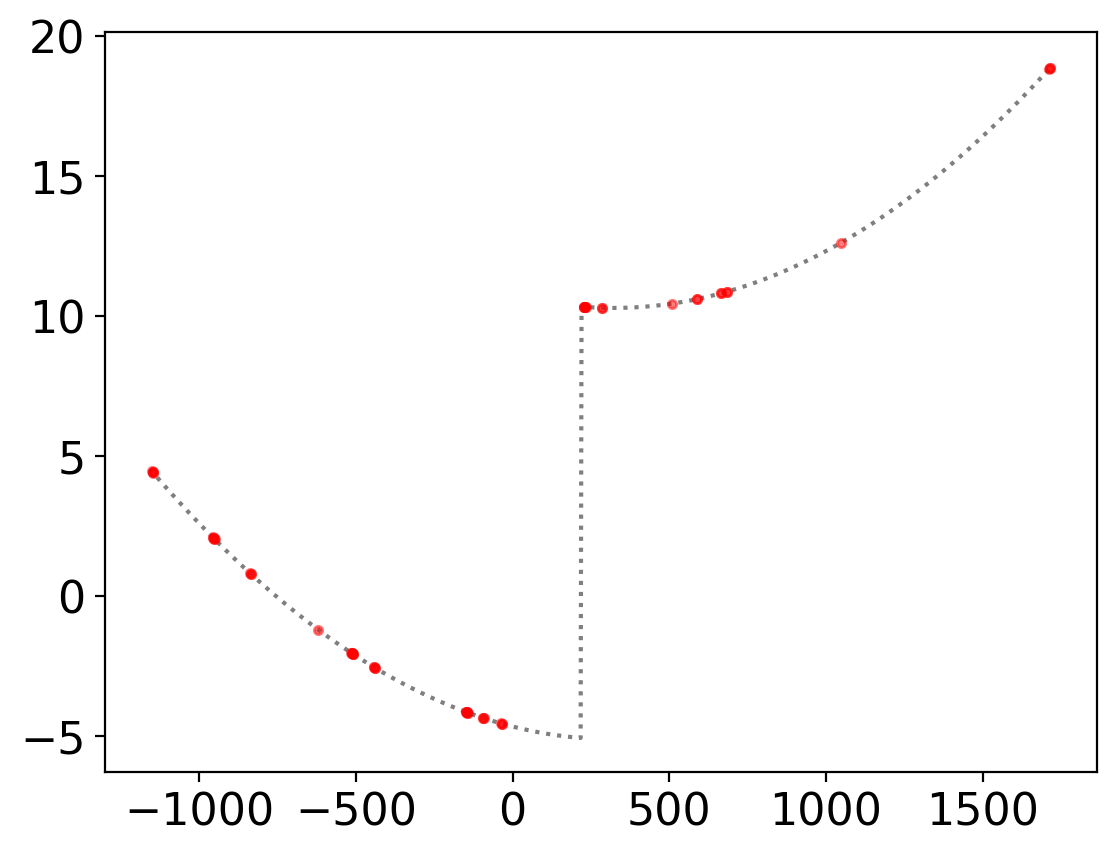

In [29]:
plt.plot(t_rv, map_soln['bkg_pred'], ":k", alpha=0.5)
plt.plot(x_rv, map_soln['bkg_noactivity'], ".r", alpha=0.5)

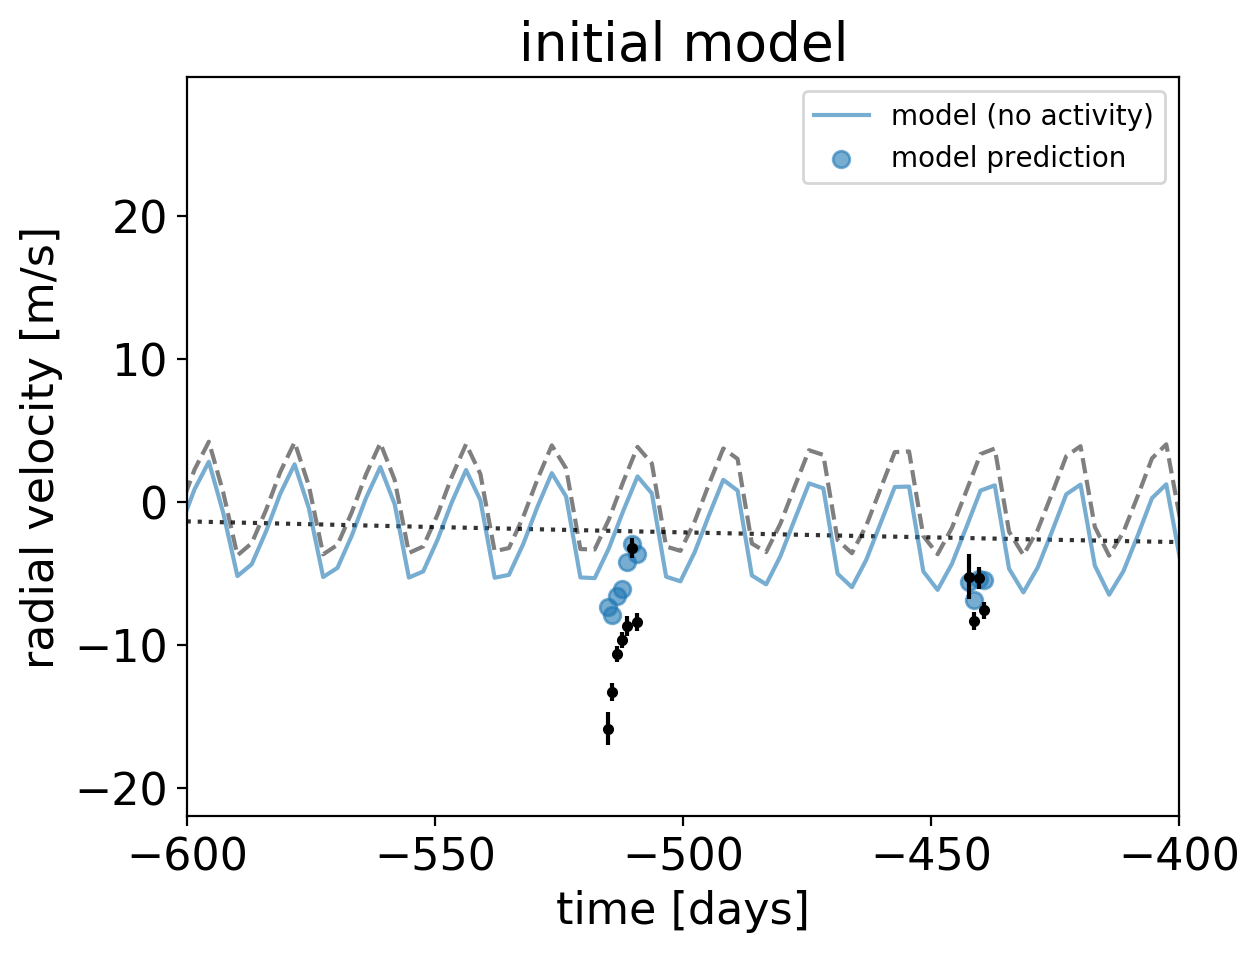

In [30]:
plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")

plt.plot(t_rv, map_soln['vrad_pred'], "--k", alpha=0.5)
plt.plot(t_rv, map_soln['bkg_pred'], ":k", alpha=0.8)
plt.plot(t_rv, map_soln['rv_model_pred'], label="model (no activity)", alpha=0.6)
plt.scatter(x_rv, map_soln['rv_model'], label="model prediction", alpha=0.6)

plt.legend(fontsize=10)
plt.xlim(t_rv.min(), t_rv.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model")
plt.xlim([-600,-400]);

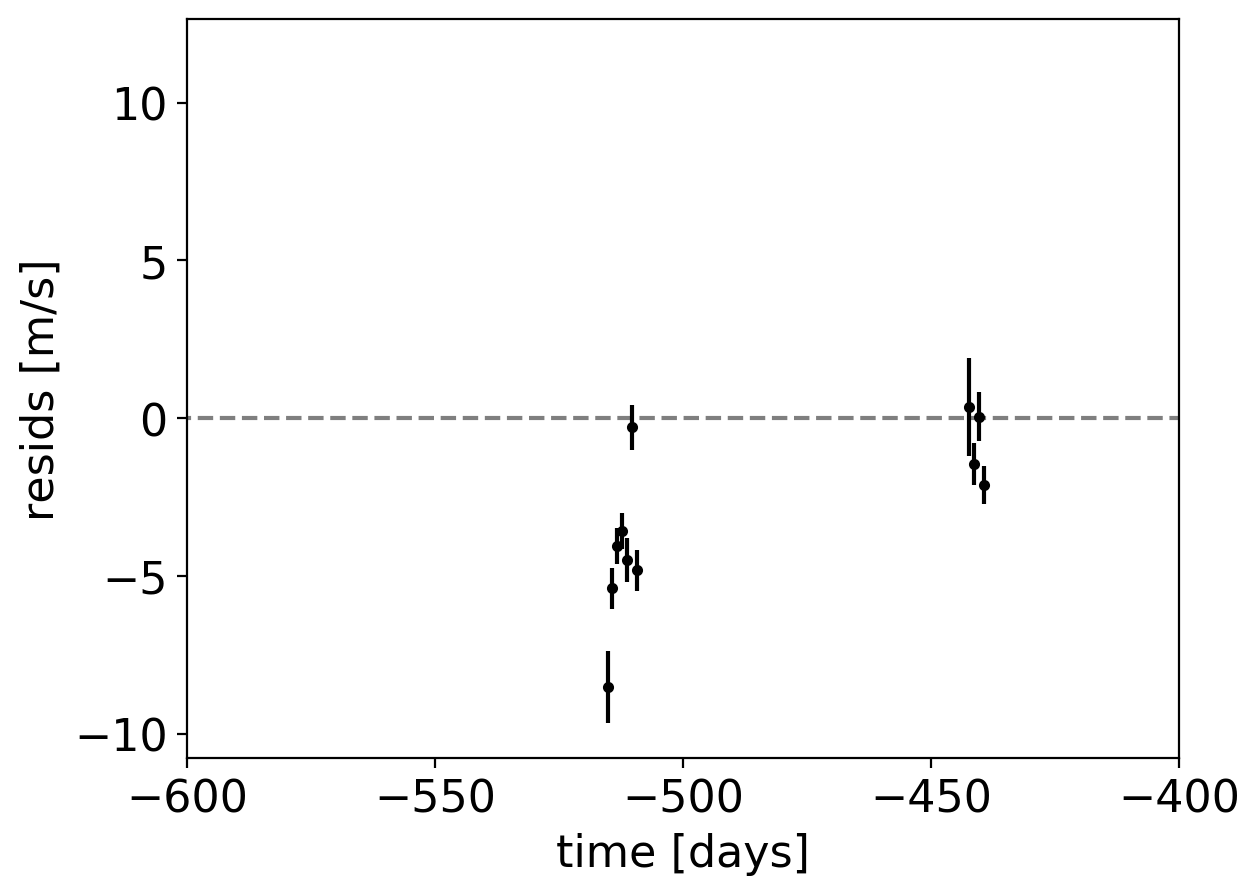

In [31]:
plt.errorbar(x_rv, y_rv - map_soln['rv_model'], yerr=yerr_rv, fmt='.k')
plt.plot(t_rv, np.zeros_like(t_rv), 'k--', alpha=0.5)
plt.xlabel("time [days]")
plt.ylabel('resids [m/s]')
plt.xlim([-600,-400]);

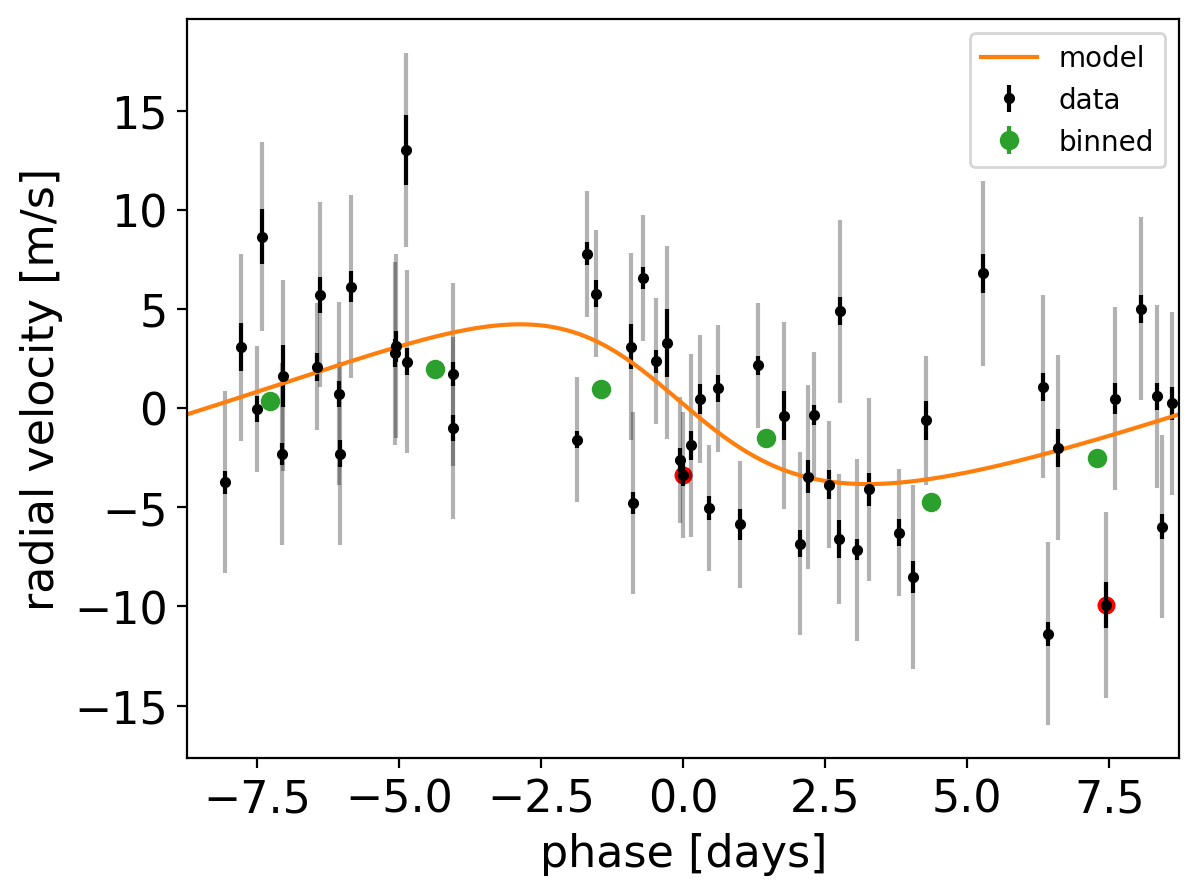

In [32]:
p = map_soln["period"]
t0 = map_soln["t0"]
jit2_pre = np.exp(2*map_soln["logs_rv_pre"])
jit2_pug = np.exp(2*map_soln["logs_rv_pug"])

bkg = map_soln["bkg"]

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold[~pug], y_rv[~pug] - bkg[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
plt.errorbar(x_fold[pug], y_rv[pug] - bkg[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")
plt.scatter(x_fold[mask], y_rv[mask] - bkg[mask], c='r', s=30)


# Bin the data
bins = np.linspace(-0.5 * p, 0.5*p, 7).flatten()
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Plot the model prediction
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
plt.plot(t_fold[inds], map_soln['vrad_pred'][inds], color="C1", label="model")


plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]");

peaks at:
1.06 days
120.07 days
1.04 days
1.06 days
1.01 days
1.04 days
1.06 days
1.06 days
1.01 days
1.01 days
542.52 days
1.06 days
17.17 days
53.62 days
1.02 days


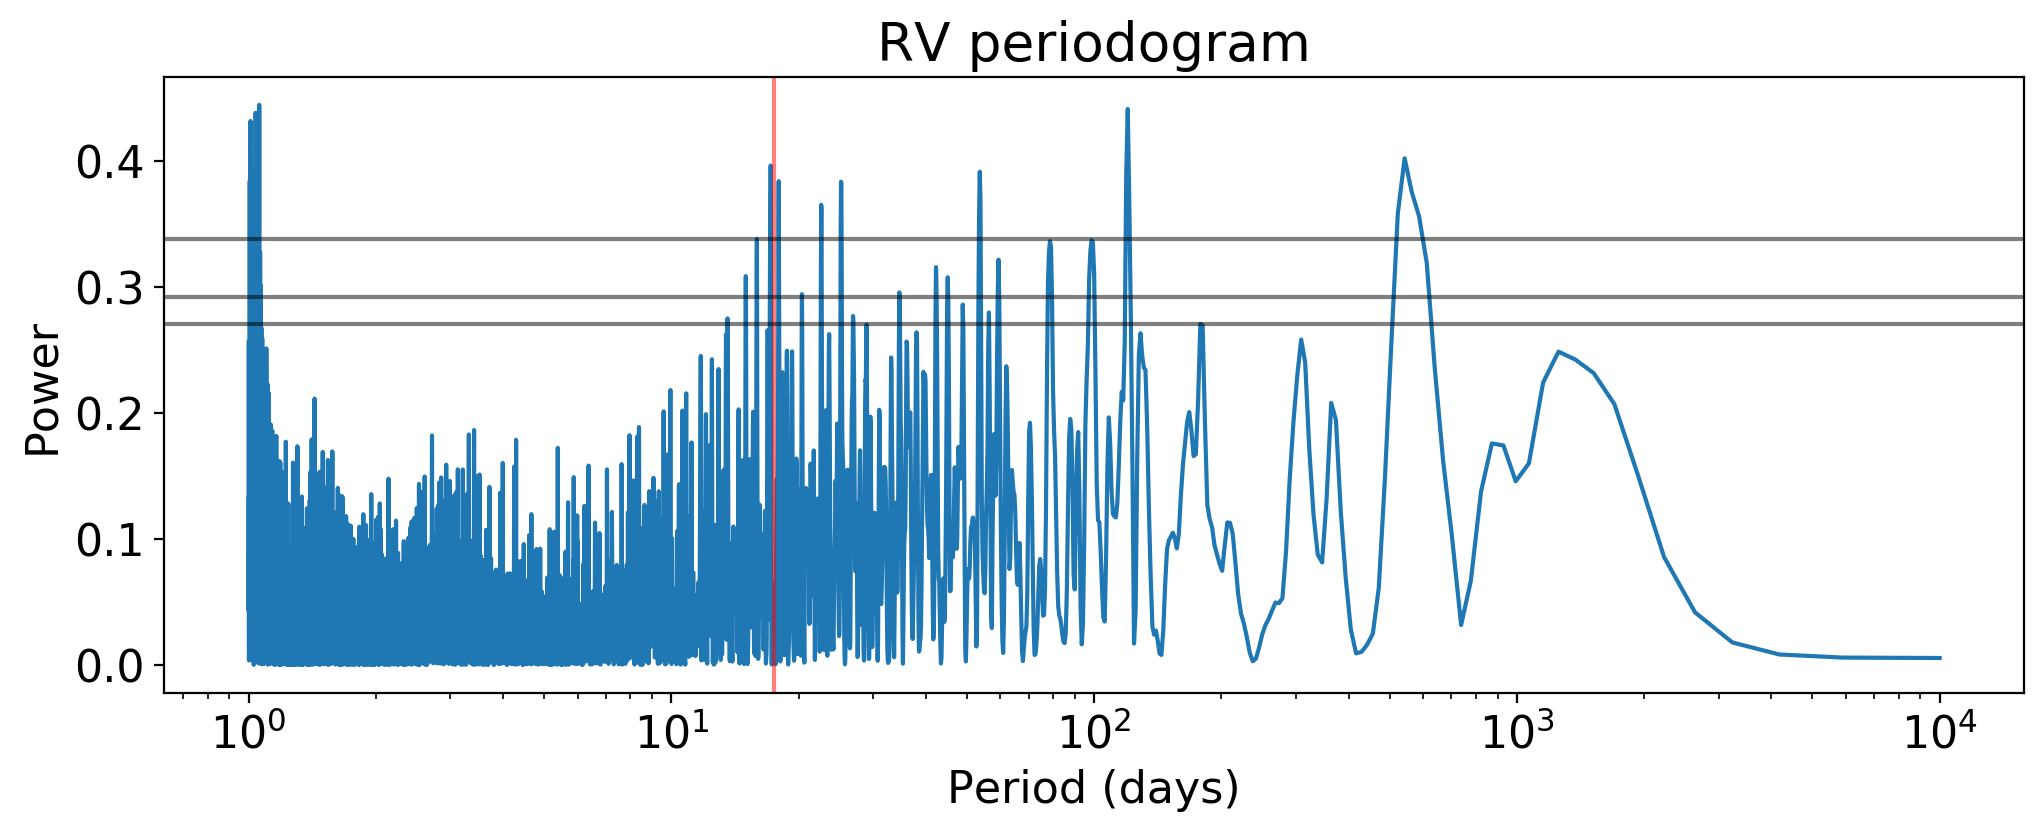

In [33]:
resids = y_rv - map_soln['rv_model']

freq, power = LombScargle(x_rv, resids, yerr_rv).autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('RV periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(15):
    print("{0:.2f} days".format(sorted_peaks[i]))

In [34]:
map_soln['ecc']

array([0.24276738])

#### Constrain eccentricity from tidal circularization?

In [35]:
from astropy.constants import G

m_env_factor = 0.005 # fraction of mass in convective zone - I'm making this up!!
# also making up stellar luminosity in the below eqn
primary_factor = ((1. * u.Lsun) / (m_env_factor * mass_radius_mu[0] * u.Msun * (mass_radius_mu[1] * u.Rsun)**2)).decompose()
q = (10 * u.Mearth / (mass_radius_mu[0] * u.Msun)).decompose()
a = (((17. * u.day)**2 * G * mass_radius_mu[0] * u.Msun / (4. * np.pi**2))**(1/3)).decompose()
dist_factor = (mass_radius_mu[1] * u.Rsun / a).decompose()
t_circ = 1./(1 * primary_factor**(1/3) * m_env_factor * q * (1. + q) * dist_factor**8)

In [36]:
t_circ.to(u.yr)

<Quantity 2.25688319e+17 yr>

In [37]:
a.to(u.AU)

<Quantity 0.12862599 AU>

#### Two planets?

In [38]:
periods = np.array([17.47114, 120.1])
t0s = np.array([1661.0628, 1000.])

n_pl = len(periods)

In [39]:
msini = xo.estimate_minimum_mass(periods, x_rv, y_rv_guess, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = np.abs(msini.to(u.M_earth))
print(msini)

[11.01388962 42.22592222] earthMass


In [40]:
model, map_soln = build_model(fwhm=True, rv_trend_order=3)

optimizing logp for variables: [offset_pug, trend, logs_rv_pug, logs_rv_pre]
53it [00:00, 99.38it/s, logp=-1.841168e+02]  
message: Desired error not necessarily achieved due to precision loss.
logp: -1739.2836353254804 -> -184.11675006154573
optimizing logp for variables: [offset_pug_fwhm, trend_fwhm]
14it [00:00, 22.39it/s, logp=-1.820215e+02] 
message: Optimization terminated successfully.
logp: -184.11675006154573 -> -182.02148269995155
optimizing logp for variables: [t0, log_period]
24it [00:00, 58.30it/s, logp=-1.797290e+02]  
message: Optimization terminated successfully.
logp: -182.02148269995158 -> -179.72900130085173
optimizing logp for variables: [log_m_pl]
17it [00:00, 41.07it/s, logp=-1.762637e+02] 
message: Optimization terminated successfully.
logp: -179.72900130085173 -> -176.26374721189686
optimizing logp for variables: [trend_fwhm, offset_pug_fwhm, trend, offset_pug, logs_rv_pug, logs_rv_pre, omega, ecc, ecc_beta, ecc_alpha, log_m_pl, t0, log_period, mr_star]
109it [0

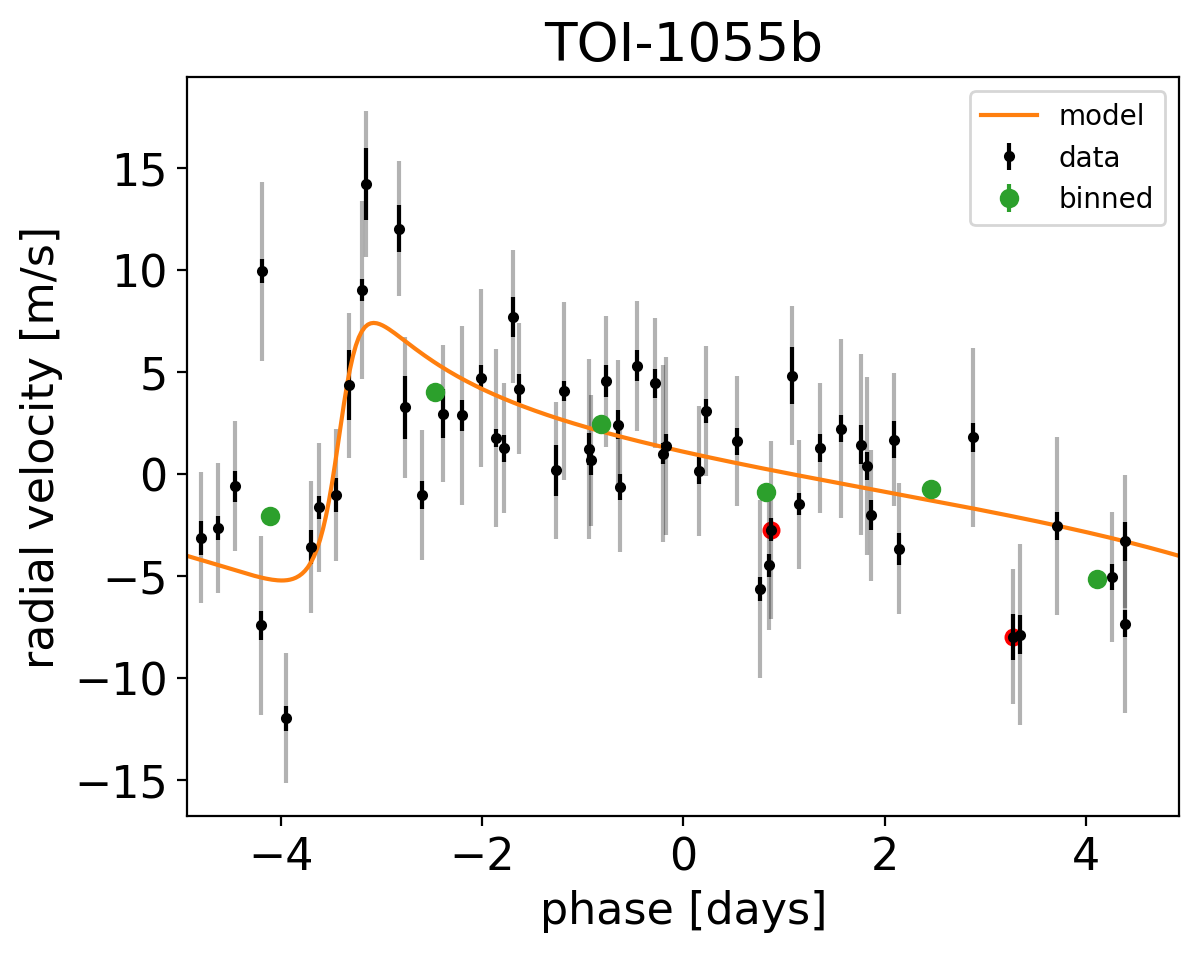

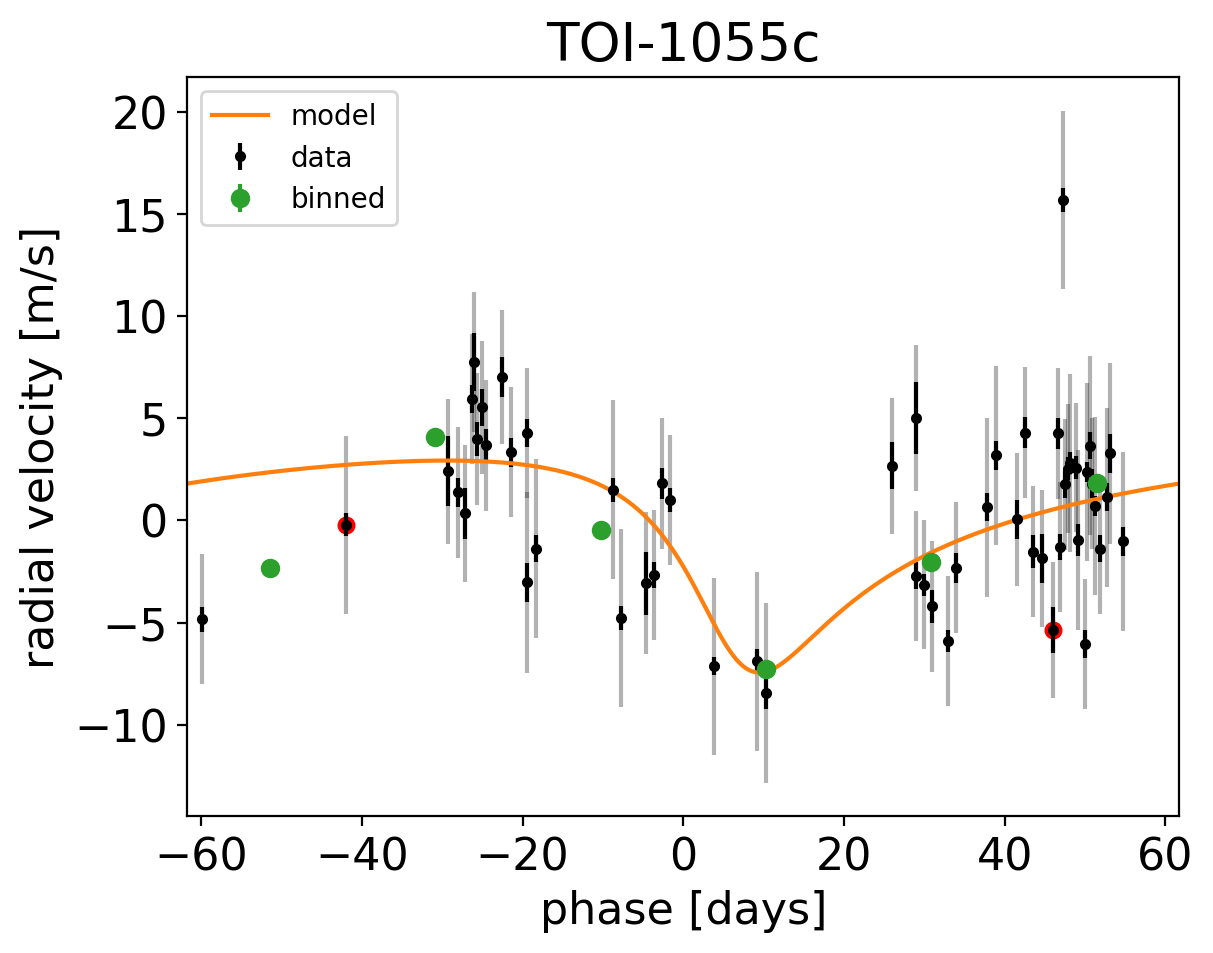

In [41]:
for n,letter in enumerate('bc'):
    plt.figure()
    
    p = map_soln["period"][n]
    t0 = map_soln["t0"][n]
    jit2_pre = np.exp(2*map_soln["logs_rv_pre"])
    jit2_pug = np.exp(2*map_soln["logs_rv_pug"])

    other = map_soln['vrad'][:,(n + 1) % 2]
    other += map_soln["bkg"]

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold[~pug], y_rv[~pug] - other[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
    plt.errorbar(x_fold[pug], y_rv[pug] - other[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    plt.scatter(x_fold[mask], y_rv[mask] - other[mask], c='r', s=30)


    # Bin the data
    bins = np.linspace(-0.5 * p, 0.5*p, 7).flatten()
    num, _ = np.histogram(x_fold, bins, weights=(y_rv - other) / yerr_rv**2)
    denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
    plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

    # Plot the model prediction
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    plt.plot(t_fold[inds], map_soln['vrad_pred'][inds,n], color="C1", label="model")


    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("TOI-1055{0}".format(letter));